# Import and Split Data

In [1]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from copy import copy

In [2]:
np.set_printoptions(precision=4)

In [3]:
def read_data(type_:str, power_transform=True):
    df = pd.read_csv("x_%s_gr_smpl.csv" % type_).astype(int)

    # label data-frame rows based on sample data
    for x in range(10):
        index = ~np.loadtxt("y_%s_smpl_%s.csv" % (type_, x), delimiter=",", skiprows=1).astype(bool)   # reversed flags (~)
        df.loc[index, 'label'] = x

    x = df.iloc[:, 0:2304].to_numpy()
    y = df.iloc[:, 2304].to_numpy()

    # Randomise instance order (forcing the same result each time)
    np.random.seed(42)
    permutation = np.random.permutation(df.shape[0])
    
    x = x[permutation]
    y = y[permutation]
    
    if power_transform:
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method='box-cox')
        pt.fit(x)
        x = pt.transform(x)
    
    return x, y

In [4]:
train_x, train_y = read_data('train')
test_x, test_y = read_data('test')

#### Experiment A (cross-validation)

In [5]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(train_x, train_y)

10

#### Experiment B (train and test datasets)

In [6]:
B_train_x = train_x
B_train_y = train_y 
B_test_x = test_x
B_test_y = test_y

#### Experiment C (train and test datasets, 4000 moved)

In [7]:
C_train_x = train_x[:-4000]
C_train_y = train_y[:-4000]
C_test_x = np.concatenate((test_x, train_x[-4000:]), axis=0)
C_test_y = np.concatenate((test_y, train_y[-4000:]), axis=0)

#### Experiment D (train and test datasets, 9000 moved)

In [8]:
D_train_x = train_x[:-9000]
D_train_y = train_y[:-9000]
D_test_x = np.concatenate((test_x, train_x[-9000:]), axis=0)
D_test_y = np.concatenate((test_y, train_y[-9000:]), axis=0)

# Tools

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_auc_score(y_pred, test_y):
    uniqueValues = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    occurCount = []
    for x in uniqueValues:
        occurCount.append(np.count_nonzero(y_pred == x))
    uniqueValues = np.array(uniqueValues)
    occurCount = np.array(occurCount)
    y_pred = label_binarize(y_pred, classes=range(0, 10))
    test_y = label_binarize(test_y, classes=range(0, 10))
    tpr = {}
    fpr = {}
    auc_val = {}
    for i in range(0, 10):
        fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_pred[:, i])
        auc_val[i] = auc(fpr[i], tpr[i])
    auc_values = [x[1] for x in auc_val.items()]
    auc_values = np.asarray(auc_values)
    weighted_product = np.multiply(occurCount, auc_values)
    weighted_product[np.isnan(weighted_product)] = 0.
    return float(weighted_product.sum())/float(occurCount.sum())

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.metrics import sensitivity_score, specificity_score

def calculate_scores(true_labels, predicted_labels):
    return {'accuracy': accuracy_score(true_labels, predicted_labels),
            'precision': precision_score(true_labels, predicted_labels, average='weighted'),
            'recall': recall_score(true_labels, predicted_labels, average='weighted'), # true positive rate
            'specificity': specificity_score(true_labels, predicted_labels, average='weighted'), # false positive rate
            'f1_score': f1_score(true_labels, predicted_labels, average='weighted'),
            'auc': get_auc_score(true_labels, predicted_labels)}

Using TensorFlow backend.


# Linear classifier

In [153]:
iterations = 5

In [158]:
linear_metrics = pd.DataFrame(columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc', 'exp'])
linear_metrics

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc, exp]
Index: []

### Define run method

In [159]:
import time
from sklearn.svm import SVC

In [160]:
def run_linear_classifier(train_x, train_y, test_x, test_y):

    # train the linear regression classifier
    classifier = SVC(kernel='linear')
    classifier.fit(train_x, train_y)

    # evaluate the classifier
    predictions = classifier.predict(test_x)
    
    scores = calculate_scores(test_y, predictions)
    
    return scores

#### Experiment A

In [161]:
X = train_x
y = train_y

start_time = time.time()
A_linear = []
for index, data in enumerate(skf.split(X, y)):
    
    # create train and test sets
    X_train, X_test = X[data[0]], X[data[1]]
    y_train, y_test = y[data[0]], y[data[1]]

    scores = run_linear_classifier(X_train, y_train, X_test, y_test)
    A_linear.append(scores)

linear_metrics.loc[len(linear_metrics)] = ['Linear', np.NaN, round(time.time() - start_time), np.NaN, *pd.DataFrame(A_linear).mean().tolist(), 'A']

#### Experiment B

In [163]:
start_time = time.time()
B_linear = []
for _ in range(iterations):
    scores = run_linear_classifier(B_train_x, B_train_y, B_test_x, B_test_y)
    B_linear.append(scores)
    
linear_metrics.loc[len(linear_metrics)] = ['Linear', np.NaN, round(time.time() - start_time), np.NaN, *pd.DataFrame(B_linear).mean().tolist(), 'B']

#### Experiment C

In [164]:
start_time = time.time()
C_linear = []
for _ in range(iterations):
    scores = run_linear_classifier(C_train_x, C_train_y, C_test_x, C_test_y)
    C_linear.append(scores)

linear_metrics.loc[len(linear_metrics)] = ['Linear', np.NaN, round(time.time() - start_time), np.NaN, *pd.DataFrame(C_linear).mean().tolist(), 'C']

#### Experiment D

In [165]:
start_time = time.time()
D_linear = []
for _ in range(iterations):
    scores = run_linear_classifier(D_train_x, D_train_y, D_test_x, D_test_y)
    D_linear.append(scores)
    
linear_metrics.loc[len(linear_metrics)] = ['Linear', np.NaN, round(time.time() - start_time), np.NaN, *pd.DataFrame(D_linear).mean().tolist(), 'D']

### Results

In [166]:
linear_metrics

classifier  optimizer seconds  epochs  accuracy  precision    recall  \
0     Linear        NaN     595     NaN  0.975276   0.975584  0.975276   
1     Linear        NaN     440     NaN  0.916067   0.917677  0.916067   
2     Linear        NaN     361     NaN  0.943329   0.944030  0.943329   
3     Linear        NaN     242     NaN  0.941913   0.943261  0.941913   

   specificity  f1_score       auc exp  
0     0.996243  0.975312  0.985707   A  
1     0.988299  0.915375  0.952968   B  
2     0.991973  0.943305  0.967888   C  
3     0.991995  0.942269  0.967345   D

# Neural Networks

#### Default Classifier

In [467]:
from keras.models import Sequential, clone_model
from keras.layers import Dense

In [468]:
default_classifier = Sequential()
default_classifier.name = 'd=[10, 10, 10]'
default_classifier.add(Dense(10, input_dim=2304, activation='relu'))
default_classifier.add(Dense(10, activation='relu'))
default_classifier.add(Dense(10, activation='softmax'))

#### Default Optimizer

In [469]:
from keras.optimizers import SGD

In [470]:
default_optimizer = SGD(lr=0.01, nesterov=False)
default_optimizer.name = 'SGD(lr=0.01)'

#### Default settings

In [471]:
default_epochs = 200

#### Functions

In [583]:
def run_classifier(classifier, optimizer, iterate, epochs, train_x, train_y, test_x, test_y, verbose: bool = True, plot_cm=True):
    
    t_hist_a = pd.DataFrame()
    v_hist_a = pd.DataFrame()
    t_hist_l = pd.DataFrame()
    v_hist_l = pd.DataFrame()
    out = []

    for i in range(iterate):
        classifier_ = clone_model(classifier)
        optimizer_ = copy(optimizer)
        
        if verbose:
            print("[%s] Running classifier: %s, %s" % (i+1, classifier_.name, optimizer_.name))

        classifier_.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_, metrics=['sparse_categorical_accuracy'])
        history = classifier_.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y), shuffle=False, batch_size=256, verbose=0)        
        
        probabilities = classifier_.predict(test_x, batch_size=1, verbose=0)
        predictions = np.array([np.argmax(x) for x in probabilities])
        scores = calculate_scores(test_y, predictions)
        out.append(scores)
        
        if plot_cm:
            from sklearn.metrics import confusion_matrix
            cm = confusion_matrix(test_y, predictions)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            df_cm = pd.DataFrame(cm, index = [str(i) for i in range(10)], columns = [str(i) for i in range(10)])
            plt.figure(figsize = (10,7))
            sn.heatmap(df_cm, annot=True)
            plt.show()
        
        t_hist_a[str(i)] = history.history['sparse_categorical_accuracy']
        v_hist_a[str(i)] = history.history['val_sparse_categorical_accuracy']
        t_hist_l[str(i)] = history.history['loss']
        v_hist_l[str(i)] = history.history['val_loss']

    return out, t_hist_a, v_hist_a, t_hist_l, v_hist_l

In [584]:
def plot_results(t_hist, v_hist, title, y_label, legend_loc):
    
    # calculate means and standard deviations
    train_means = t_hist.mean(axis=1)
    train_std = t_hist.std(axis=1)
    val_means = v_hist.mean(axis=1)
    val_std = v_hist.std(axis=1)

    # plot train and validation loss
    plt.plot(train_means, color='blue', label='train', linewidth=0.8)
    plt.fill_between(range(t_hist.shape[0]), train_means-train_std, train_means+train_std, alpha=0.15)
    plt.plot(val_means, color='orange', label='validation', linewidth=0.8)
    plt.fill_between(range(v_hist.shape[0]), val_means-val_std, val_means+val_std, alpha=0.15)
    plt.title(title, fontsize=10)
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0.0, 1.0)
    plt.legend(['train', 'validation'], loc=legend_loc)
    plt.show()

    from pylab import rcParams
    rcParams['figure.figsize'] = 3, 3

### Experiment A

In [627]:
X = train_x
y = train_y

def run_exp_A(c, o, i, e):
    import time
    start_time = time.time()
    t_hist_a = pd.DataFrame()
    v_hist_a = pd.DataFrame()
    t_hist_l = pd.DataFrame()
    v_hist_l = pd.DataFrame()
    scores = []
    
    for idx, data in enumerate(skf.split(X, y)):

        # create train and test sets
        X_train, X_test = X[data[0]], X[data[1]]
        y_train, y_test = y[data[0]], y[data[1]]
        
        scores_, t_hist_a_, v_hist_a_, t_hist_l_, v_hist_l_ = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                             train_x=X_train, train_y=y_train,
                                                                             test_x=X_test, test_y=y_test,
                                                                             plot_cm=False)
        scores.extend(scores_)

        t_hist_a[str(idx)] = t_hist_a_.loc[:,'0']
        v_hist_a[str(idx)] = v_hist_a_.loc[:,'0']
        t_hist_l[str(idx)] = t_hist_l_.loc[:,'0']
        v_hist_l[str(idx)] = v_hist_l_.loc[:,'0']
        
    return scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l

#### Impact of Network Dimensions

In [615]:
classifier1 = Sequential()
classifier1.name = 'd=[5, 10]'
classifier1.add(Dense(5, input_dim=2304, activation='relu'))
classifier1.add(Dense(10, activation='softmax'))

classifier2 = Sequential()
classifier2.name = 'd=[10, 10]'
classifier2.add(Dense(10, input_dim=2304, activation='relu'))
classifier2.add(Dense(10, activation='softmax'))

classifier3 = Sequential()
classifier3.name = 'd=[30, 10]'
classifier3.add(Dense(30, input_dim=2304, activation='relu'))
classifier3.add(Dense(10, activation='softmax'))

classifier4 = Sequential()
classifier4.name = 'd=[5, 5, 10]'
classifier4.add(Dense(5, input_dim=2304, activation='relu'))
classifier4.add(Dense(5, activation='relu'))
classifier4.add(Dense(10, activation='softmax'))

classifier5 = Sequential()
classifier5.name = 'd=[10, 10, 10]'
classifier5.add(Dense(10, input_dim=2304, activation='relu'))
classifier5.add(Dense(10, activation='relu'))
classifier5.add(Dense(10, activation='softmax'))

classifier6 = Sequential()
classifier6.name = 'd=[30, 30, 10]'
classifier6.add(Dense(30, input_dim=2304, activation='relu'))
classifier6.add(Dense(30, activation='relu'))
classifier6.add(Dense(10, activation='softmax'))

all_classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6]

In [616]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
a_metrics_1 = pd.DataFrame(columns=columns)
a_metrics_1

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

[1] Running classifier: d=[5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


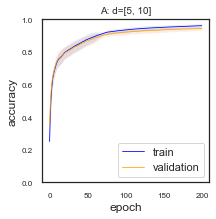

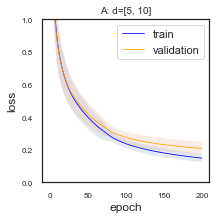

[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10], SGD(lr=0.01)


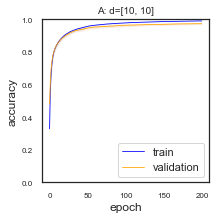

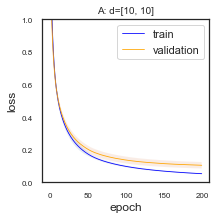

[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 10], SGD(lr=0.01)


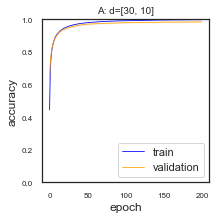

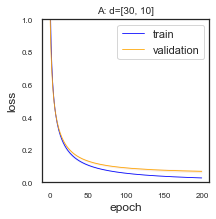

[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)
[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


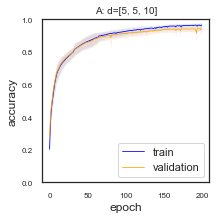

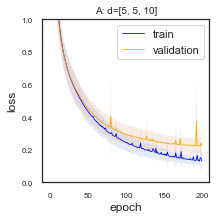

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


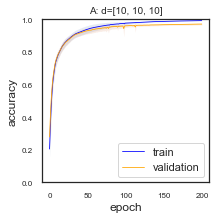

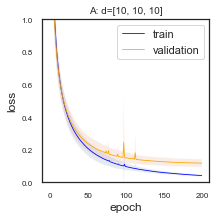

[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)
[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)


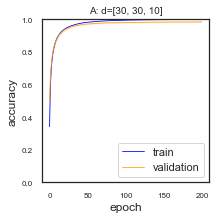

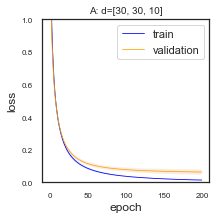

In [617]:
i = 1  # number of iterations
e = default_epochs  # number of epochs per iteration
o = default_optimizer  # default optimizer

for c in all_classifiers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_exp_A(c, o, i, e)
    plot_results(t_hist_a, v_hist_a, "A: %s" % c.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "A: %s" % c.name, 'loss', 'upper right')
    a_metrics_1.loc[len(a_metrics_1)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [618]:
a_metrics_1

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0       d=[5, 10]  SGD(lr=0.01)    2203    200  0.943286   0.941155  0.943286   
1      d=[10, 10]  SGD(lr=0.01)    1777    200  0.972354   0.972579  0.972354   
2      d=[30, 10]  SGD(lr=0.01)    1817    200  0.983570   0.983754  0.983570   
3    d=[5, 5, 10]  SGD(lr=0.01)    1855    200  0.940600   0.936978  0.940600   
4  d=[10, 10, 10]  SGD(lr=0.01)    1780    200  0.970300   0.970525  0.970300   
5  d=[30, 30, 10]  SGD(lr=0.01)    1901    200  0.983491   0.983660  0.983491   

   specificity  f1_score       auc  
0     0.992147  0.939801  0.965293  
1     0.995715  0.972340  0.984219  
2     0.997501  0.983581  0.990689  
3     0.991995  0.937755  0.962824  
4     0.995699  0.970279  0.983123  
5     0.997469  0.983502  0.990569

#### Impact of Learning Rate

In [619]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
a_metrics_2 = pd.DataFrame(columns=columns)
a_metrics_2

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [620]:
o1 = SGD(lr=0.0001, nesterov=False)  
o1.name = 'SGD(lr=0.0001)'

o2 = SGD(lr=0.001, nesterov=False)  
o2.name = 'SGD(lr=0.001)'

o3 = SGD(lr=0.01, nesterov=False)  
o3.name = 'SGD(lr=0.01)'

o4 = SGD(lr=0.1, nesterov=False)  
o4.name = 'SGD(lr=0.1)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


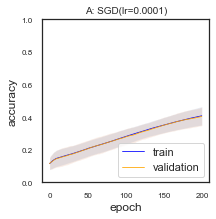

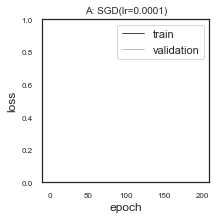

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


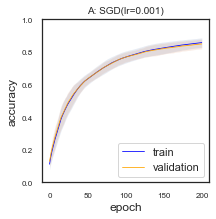

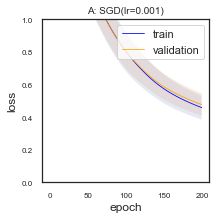

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


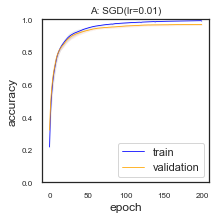

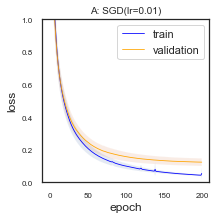

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)


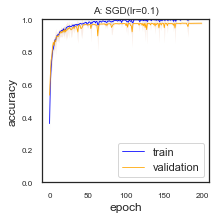

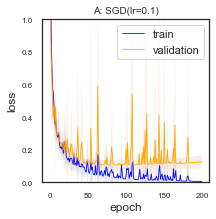

In [621]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_exp_A(c, o, i, e)
    plot_results(t_hist_a, v_hist_a, "A: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "A: %s" % o.name, 'loss', 'upper right')
    a_metrics_2.loc[len(a_metrics_2)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [622]:
a_metrics_2

classifier       optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]  SGD(lr=0.0001)    2158    200  0.404265   0.411619   
1  d=[10, 10, 10]   SGD(lr=0.001)    2010    200  0.848420   0.818372   
2  d=[10, 10, 10]    SGD(lr=0.01)    2009    200  0.968088   0.968346   
3  d=[10, 10, 10]     SGD(lr=0.1)    2090    200  0.975671   0.975955   

     recall  specificity  f1_score       auc  
0  0.404265     0.902374  0.341587  0.615113  
1  0.848420     0.974243  0.825722  0.881773  
2  0.968088     0.995442  0.968013  0.981888  
3  0.975671     0.996384  0.975671  0.986148

#### Impact of Momentum

In [628]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
a_metrics_3 = pd.DataFrame(columns=columns)
a_metrics_3

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [629]:
o1 = SGD(lr=0.01, momentum=0.0, nesterov=False)
o1.name = 'SGD(lr=0.01, m=0.0)'

o2 = SGD(lr=0.01, momentum=0.5, nesterov=False)
o2.name = 'SGD(lr=0.01, m=0.5)'

o3 = SGD(lr=0.01, momentum=0.9, nesterov=False)
o3.name = 'SGD(lr=0.01, m=0.9)'

o4 = SGD(lr=0.01, momentum=0.99, nesterov=False)
o4.name = 'SGD(lr=0.01, m=0.99)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)


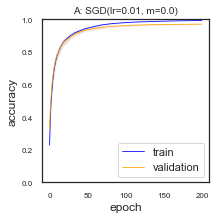

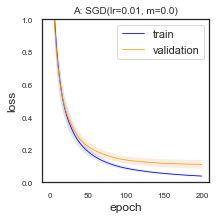

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)


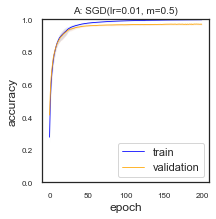

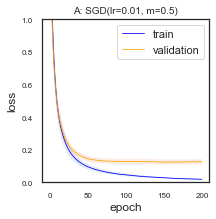

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)


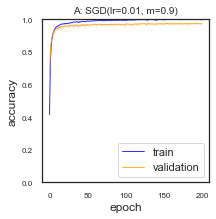

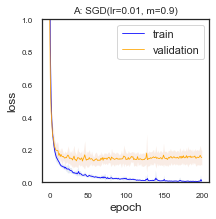

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if n

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


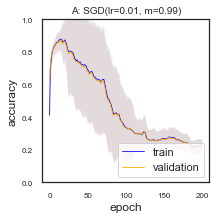

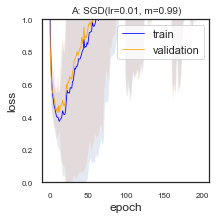

In [630]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_exp_A(c, o, i, e)
    plot_results(t_hist_a, v_hist_a, "A: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "A: %s" % o.name, 'loss', 'upper right')
    a_metrics_3.loc[len(a_metrics_3)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [631]:
a_metrics_3

classifier             optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]   SGD(lr=0.01, m=0.0)    2262    200  0.970063   0.970352   
1  d=[10, 10, 10]   SGD(lr=0.01, m=0.5)    2375    200  0.970142   0.970369   
2  d=[10, 10, 10]   SGD(lr=0.01, m=0.9)    2273    200  0.973539   0.973801   
3  d=[10, 10, 10]  SGD(lr=0.01, m=0.99)    2095    200  0.221801   0.203615   

     recall  specificity  f1_score       auc  
0  0.970063     0.995603  0.970043  0.983013  
1  0.970142     0.995539  0.970132  0.982996  
2  0.973539     0.996110  0.973563  0.984872  
3  0.221801     0.841749  0.123845  0.270494

### Increasing number of epochs

In [632]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
a_metrics_4 = pd.DataFrame(columns=columns)
a_metrics_4

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)
[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


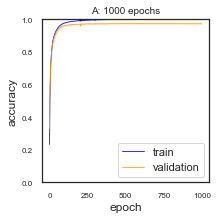

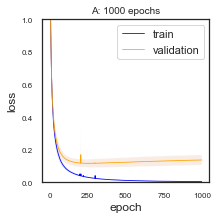

In [633]:
i = 1  # number of iterations
e = 1000  # number of epochs per iteration
c = default_classifier
o = default_optimizer

start_time = time()
scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_exp_A(c, o, i, e)
plot_results(t_hist_a, v_hist_a, "A: %s epochs" % e, 'accuracy', 'lower right')
plot_results(t_hist_l, v_hist_l, "A: %s epochs" % e, 'loss', 'upper right')
a_metrics_4.loc[len(a_metrics_4)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [634]:
a_metrics_4

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0  d=[10, 10, 10]  SGD(lr=0.01)    9253   1000  0.972512   0.972716  0.972512   

   specificity  f1_score       auc  
0     0.995882  0.972483  0.984281

### Experiment B

In [478]:
from time import time

In [479]:
_train_x, _train_y, _test_x, _test_y = B_train_x, B_train_y, B_test_x, B_test_y

#### Impact of Network Dimensions

In [480]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
b_metrics_1 = pd.DataFrame(columns=columns)
b_metrics_1

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [481]:
classifier1 = Sequential()
classifier1.name = 'd=[5, 10]'
classifier1.add(Dense(5, input_dim=2304, activation='relu'))
classifier1.add(Dense(10, activation='softmax'))

classifier2 = Sequential()
classifier2.name = 'd=[10, 10]'
classifier2.add(Dense(10, input_dim=2304, activation='relu'))
classifier2.add(Dense(10, activation='softmax'))

classifier3 = Sequential()
classifier3.name = 'd=[30, 10]'
classifier3.add(Dense(30, input_dim=2304, activation='relu'))
classifier3.add(Dense(10, activation='softmax'))

classifier4 = Sequential()
classifier4.name = 'd=[5, 5, 10]'
classifier4.add(Dense(5, input_dim=2304, activation='relu'))
classifier4.add(Dense(5, activation='relu'))
classifier4.add(Dense(10, activation='softmax'))

classifier5 = Sequential()
classifier5.name = 'd=[10, 10, 10]'
classifier5.add(Dense(10, input_dim=2304, activation='relu'))
classifier5.add(Dense(10, activation='relu'))
classifier5.add(Dense(10, activation='softmax'))

classifier6 = Sequential()
classifier6.name = 'd=[30, 30, 10]'
classifier6.add(Dense(30, input_dim=2304, activation='relu'))
classifier6.add(Dense(30, activation='relu'))
classifier6.add(Dense(10, activation='softmax'))

all_classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6]

[1] Running classifier: d=[5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


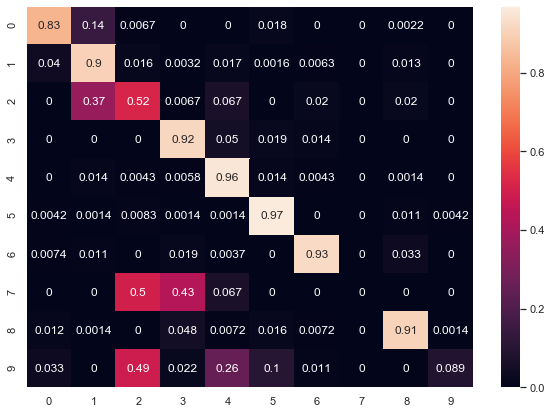

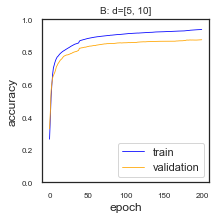

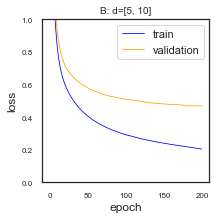

[1] Running classifier: d=[10, 10], SGD(lr=0.01)


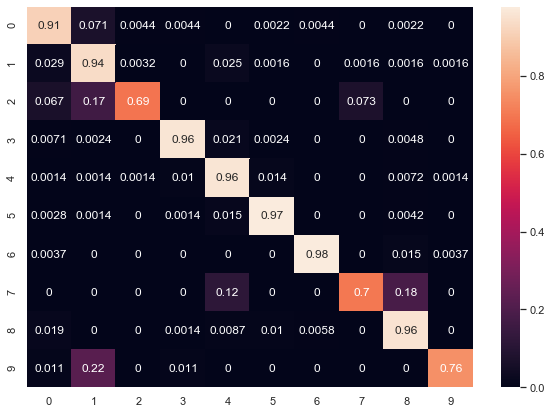

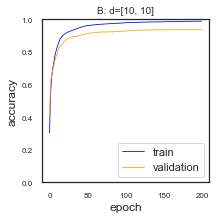

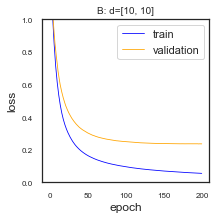

[1] Running classifier: d=[30, 10], SGD(lr=0.01)


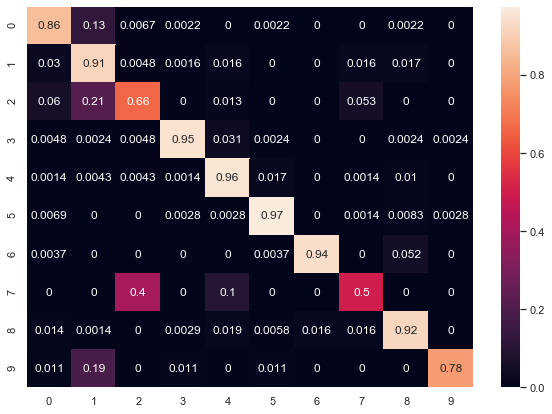

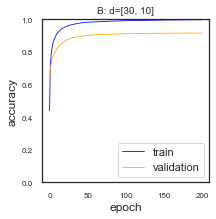

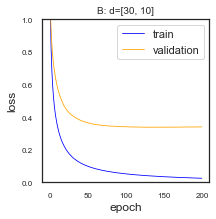

[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


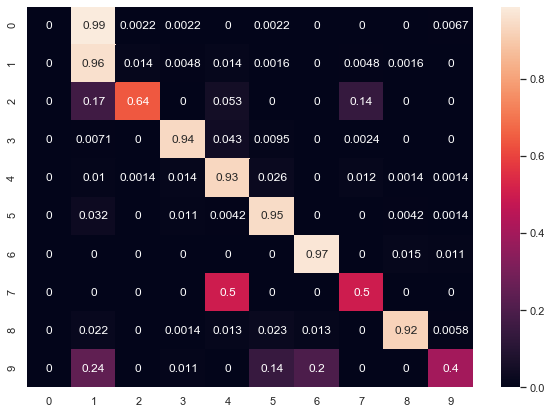

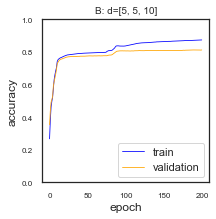

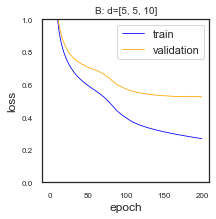

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


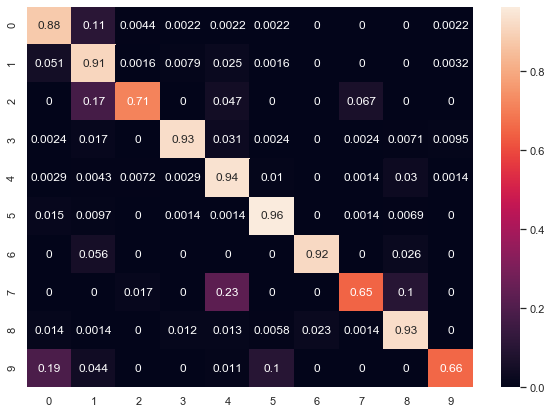

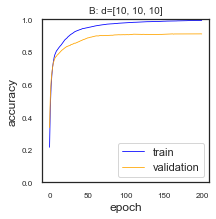

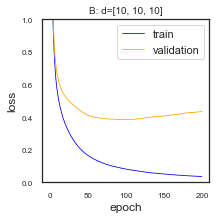

[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)


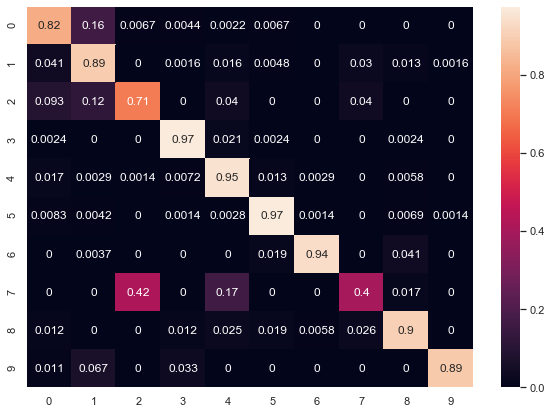

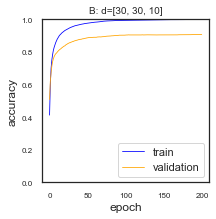

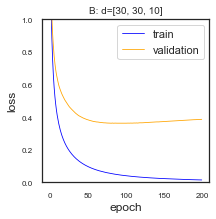

In [482]:
i = 1  # number of iterations
e = default_epochs
o = default_optimizer  # default optimizer

for c in all_classifiers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "B: %s" % c.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "B: %s" % c.name, 'loss', 'upper right')
    b_metrics_1.loc[len(b_metrics_1)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [483]:
b_metrics_1

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0       d=[5, 10]  SGD(lr=0.01)     199    200  0.874101   0.861854  0.874101   
1      d=[10, 10]  SGD(lr=0.01)     194    200  0.936930   0.937670  0.936930   
2      d=[30, 10]  SGD(lr=0.01)     197    200  0.915108   0.915913  0.915108   
3    d=[5, 5, 10]  SGD(lr=0.01)     198    200  0.811751   0.759970  0.811751   
4  d=[10, 10, 10]  SGD(lr=0.01)     195    200  0.909832   0.911002  0.909832   
5  d=[30, 30, 10]  SGD(lr=0.01)     209    200  0.905995   0.907183  0.905995   

   specificity  f1_score       auc  
0     0.982424  0.862084  0.917286  
1     0.990025  0.936085  0.965023  
2     0.987903  0.914872  0.952763  
3     0.968885  0.774180  0.821213  
4     0.986112  0.909209  0.949754  
5     0.986772  0.906125  0.947425

#### Impact of Learning Rate

In [484]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
b_metrics_2 = pd.DataFrame(columns=columns)
b_metrics_2

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [485]:
o1 = SGD(lr=0.0001, nesterov=False)  
o1.name = 'SGD(lr=0.0001)'

o2 = SGD(lr=0.001, nesterov=False)  
o2.name = 'SGD(lr=0.001)'

o3 = SGD(lr=0.01, nesterov=False)  
o3.name = 'SGD(lr=0.01)'

o4 = SGD(lr=0.1, nesterov=False)  
o4.name = 'SGD(lr=0.1)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


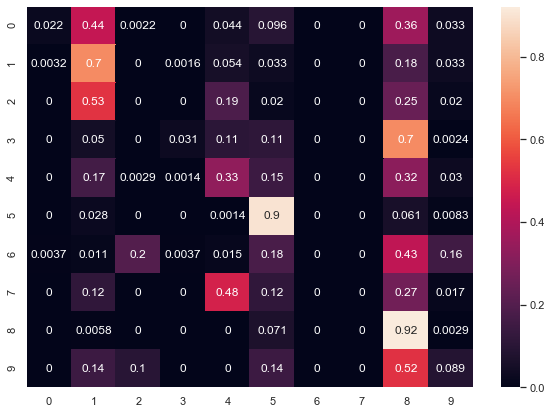

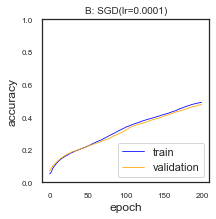

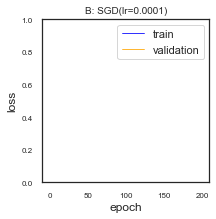

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


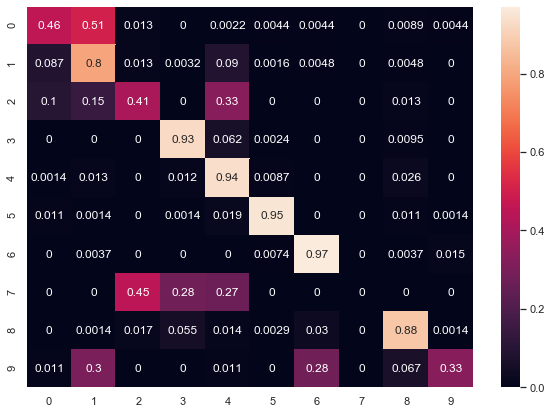

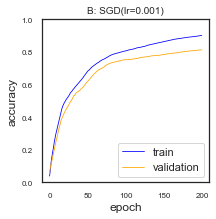

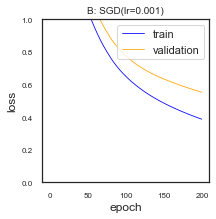

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


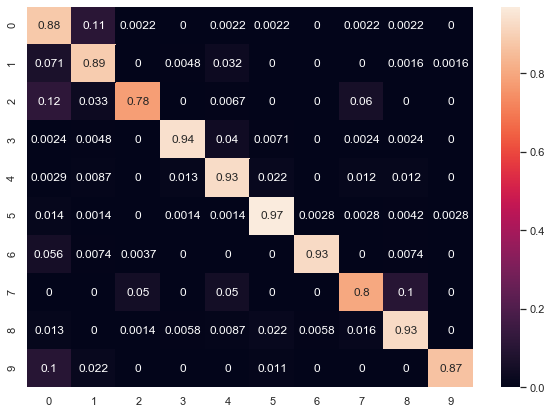

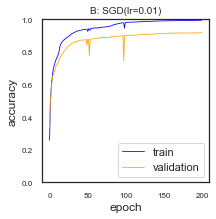

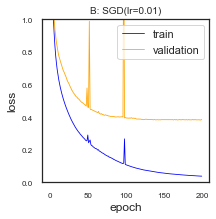

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)


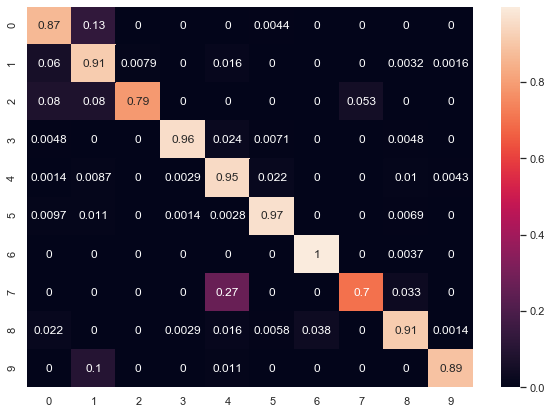

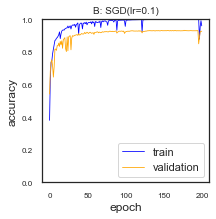

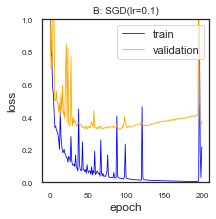

In [486]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "B: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "B: %s" % o.name, 'loss', 'upper right')
    b_metrics_2.loc[len(b_metrics_2)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [487]:
b_metrics_2

classifier       optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]  SGD(lr=0.0001)     199    200  0.476019   0.514138   
1  d=[10, 10, 10]   SGD(lr=0.001)     197    200  0.812470   0.803300   
2  d=[10, 10, 10]    SGD(lr=0.01)     190    200  0.917026   0.921104   
3  d=[10, 10, 10]     SGD(lr=0.1)     195    200  0.925659   0.927252   

     recall  specificity  f1_score       auc  
0  0.476019     0.904916  0.389930  0.687768  
1  0.812470     0.971001  0.799283  0.883273  
2  0.917026     0.988113  0.918069  0.954691  
3  0.925659     0.988708  0.925606  0.958334

#### Impact of Momentum

In [488]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
b_metrics_3 = pd.DataFrame(columns=columns)
b_metrics_3

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [489]:
o1 = SGD(lr=0.01, momentum=0.0, nesterov=False)
o1.name = 'SGD(lr=0.01, m=0.0)'

o2 = SGD(lr=0.01, momentum=0.5, nesterov=False)
o2.name = 'SGD(lr=0.01, m=0.5)'

o3 = SGD(lr=0.01, momentum=0.9, nesterov=False)
o3.name = 'SGD(lr=0.01, m=0.9)'

o4 = SGD(lr=0.01, momentum=0.99, nesterov=False)
o4.name = 'SGD(lr=0.01, m=0.99)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)


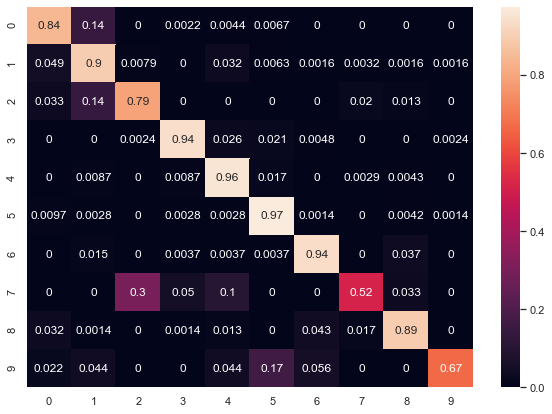

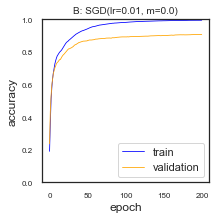

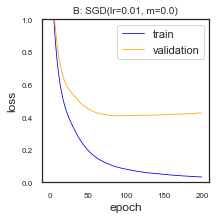

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)


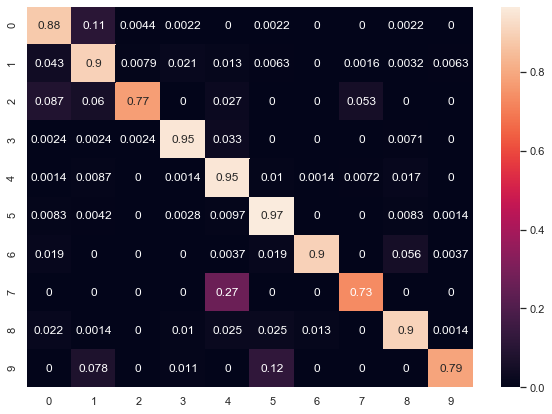

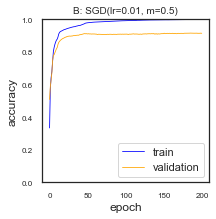

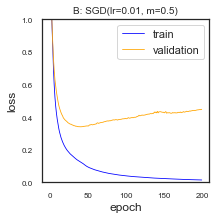

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)


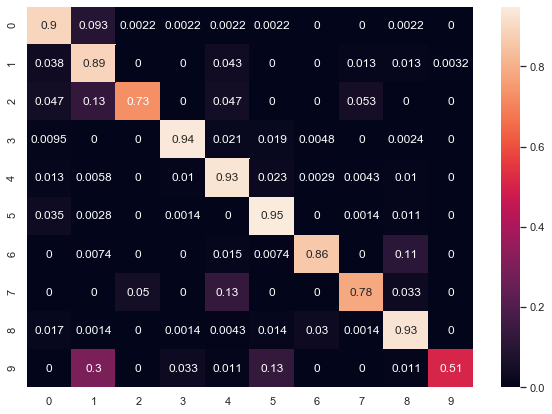

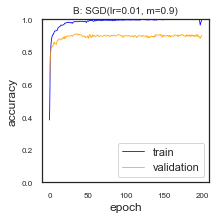

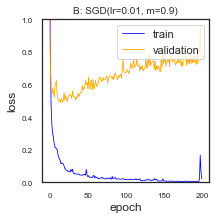

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


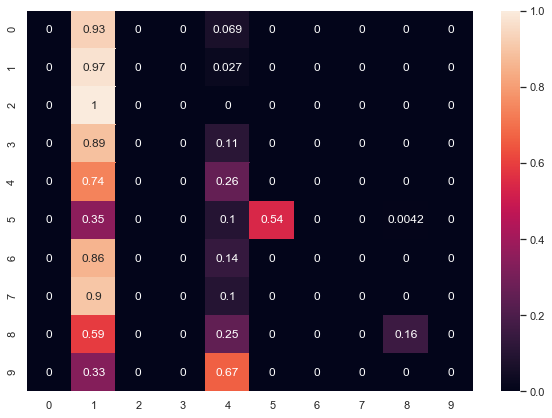

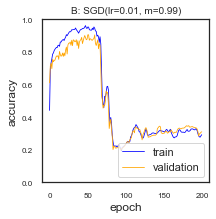

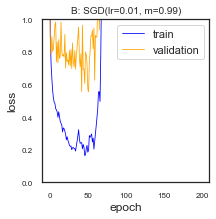

In [490]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "B: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "B: %s" % o.name, 'loss', 'upper right')
    b_metrics_3.loc[len(b_metrics_3)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [491]:
b_metrics_3

classifier             optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]   SGD(lr=0.01, m=0.0)     195    200  0.906954   0.907744   
1  d=[10, 10, 10]   SGD(lr=0.01, m=0.5)     191    200  0.913909   0.914525   
2  d=[10, 10, 10]   SGD(lr=0.01, m=0.9)     193    200  0.901918   0.904364   
3  d=[10, 10, 10]  SGD(lr=0.01, m=0.99)     193    200  0.309592   0.411561   

     recall  specificity  f1_score       auc  
0  0.906954     0.986567  0.906149  0.947820  
1  0.913909     0.986497  0.913558  0.951383  
2  0.901918     0.984611  0.900769  0.945821  
3  0.309592     0.874944  0.261937  0.500668

### Increasing number of epochs

In [492]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
b_metrics_4 = pd.DataFrame(columns=columns)
b_metrics_4

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


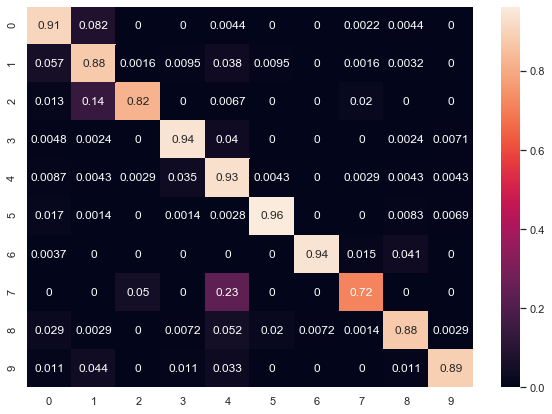

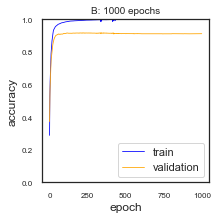

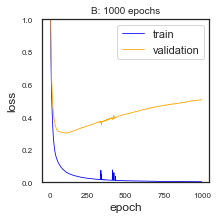

In [493]:
i = 1  # number of iterations
e = 1000  # number of epochs per iteration
c = default_classifier
o = default_optimizer


start_time = time()
scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
plot_results(t_hist_a, v_hist_a, "B: %s epochs" % e, 'accuracy', 'lower right')
plot_results(t_hist_l, v_hist_l, "B: %s epochs" % e, 'loss', 'upper right')
b_metrics_4.loc[len(b_metrics_4)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [494]:
b_metrics_4

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0  d=[10, 10, 10]  SGD(lr=0.01)     905   1000  0.911271   0.913479  0.911271   

   specificity  f1_score       auc  
0     0.986399  0.911454  0.950101

### Experiment C

In [495]:
_train_x, _train_y, _test_x, _test_y = C_train_x, C_train_y, C_test_x, C_test_y

#### Impact of Network Dimensions

In [496]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
c_metrics_1 = pd.DataFrame(columns=columns)
c_metrics_1

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [497]:
classifier1 = Sequential()
classifier1.name = 'd=[5, 10]'
classifier1.add(Dense(5, input_dim=2304, activation='relu'))
classifier1.add(Dense(10, activation='softmax'))

classifier2 = Sequential()
classifier2.name = 'd=[10, 10]'
classifier2.add(Dense(10, input_dim=2304, activation='relu'))
classifier2.add(Dense(10, activation='softmax'))

classifier3 = Sequential()
classifier3.name = 'd=[30, 10]'
classifier3.add(Dense(30, input_dim=2304, activation='relu'))
classifier3.add(Dense(10, activation='softmax'))

classifier4 = Sequential()
classifier4.name = 'd=[5, 5, 10]'
classifier4.add(Dense(5, input_dim=2304, activation='relu'))
classifier4.add(Dense(5, activation='relu'))
classifier4.add(Dense(10, activation='softmax'))

classifier5 = Sequential()
classifier5.name = 'd=[10, 10, 10]'
classifier5.add(Dense(10, input_dim=2304, activation='relu'))
classifier5.add(Dense(10, activation='relu'))
classifier5.add(Dense(10, activation='softmax'))

classifier6 = Sequential()
classifier6.name = 'd=[30, 30, 10]'
classifier6.add(Dense(30, input_dim=2304, activation='relu'))
classifier6.add(Dense(30, activation='relu'))
classifier6.add(Dense(10, activation='softmax'))

all_classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6]

[1] Running classifier: d=[5, 10], SGD(lr=0.01)


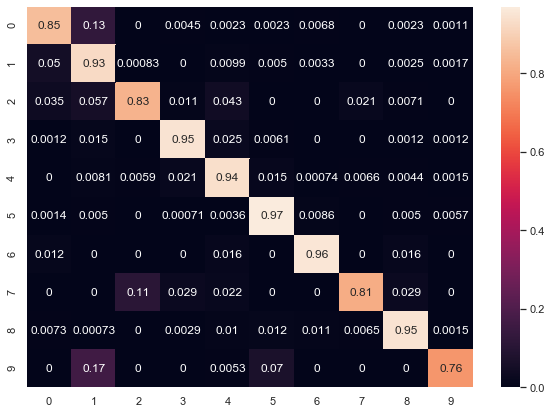

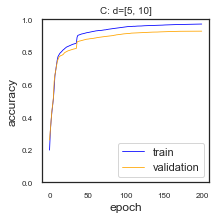

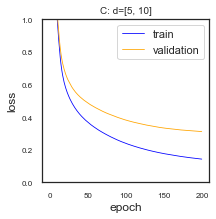

[1] Running classifier: d=[10, 10], SGD(lr=0.01)


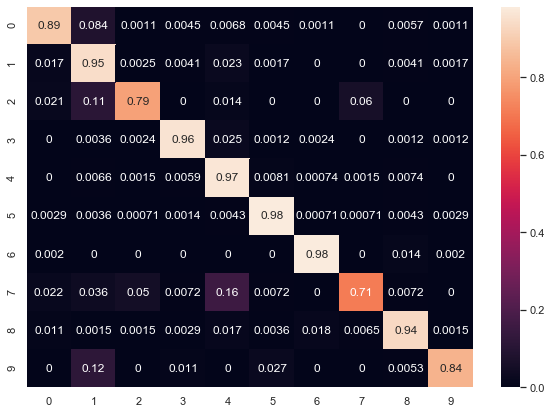

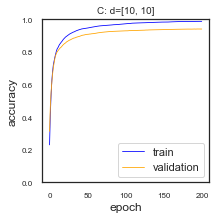

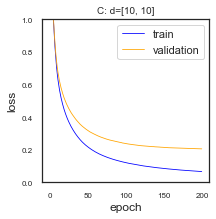

[1] Running classifier: d=[30, 10], SGD(lr=0.01)


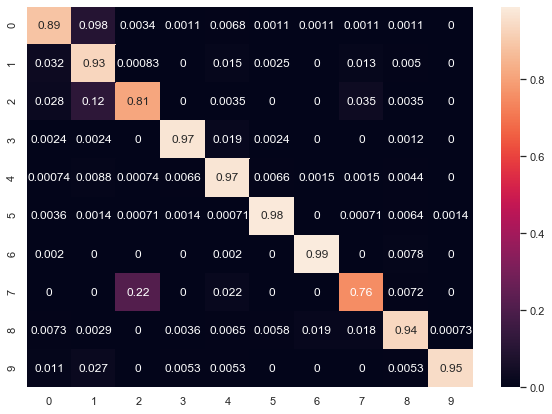

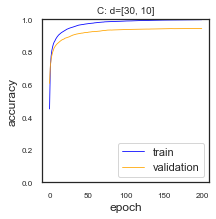

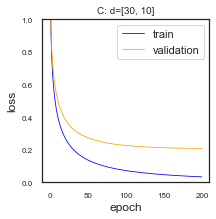

[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


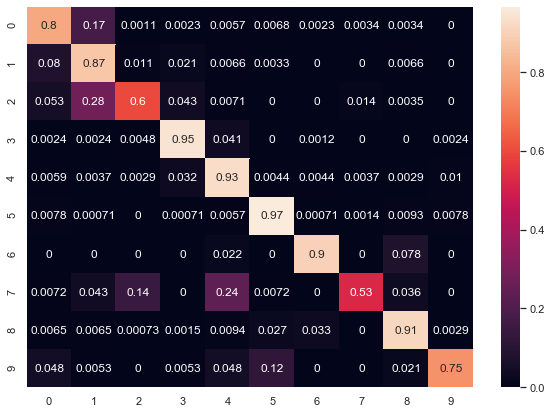

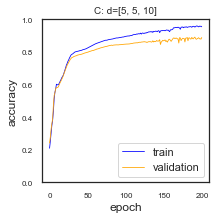

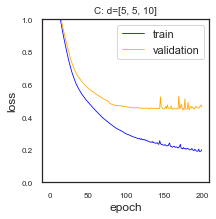

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


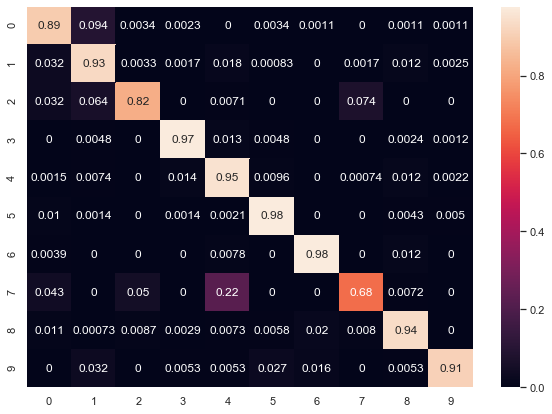

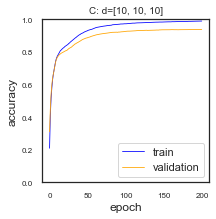

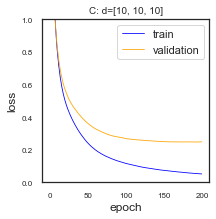

[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)


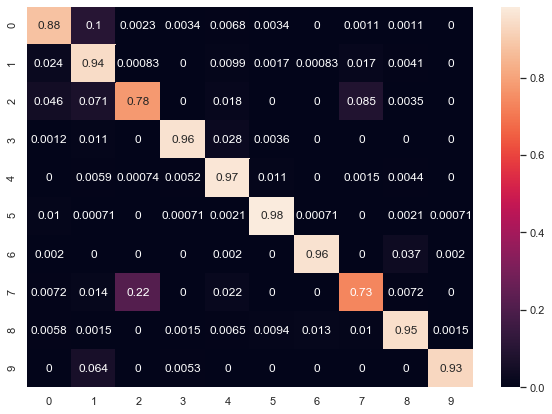

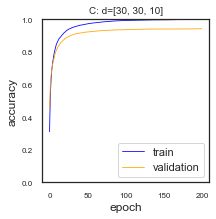

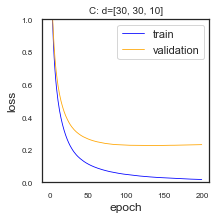

In [498]:
i = 1  # number of iterations
e = default_epochs
o = default_optimizer  # default optimizer

for c in all_classifiers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "C: %s" % c.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "C: %s" % c.name, 'loss', 'upper right')
    c_metrics_1.loc[len(c_metrics_1)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [499]:
c_metrics_1

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0       d=[5, 10]  SGD(lr=0.01)     199    200  0.926805   0.927499  0.926805   
1      d=[10, 10]  SGD(lr=0.01)     193    200  0.939902   0.940556  0.939902   
2      d=[30, 10]  SGD(lr=0.01)     210    200  0.943452   0.944619  0.943452   
3    d=[5, 5, 10]  SGD(lr=0.01)     202    200  0.887882   0.887435  0.887882   
4  d=[10, 10, 10]  SGD(lr=0.01)     193    200  0.936965   0.936822  0.936965   
5  d=[30, 30, 10]  SGD(lr=0.01)     208    200  0.941371   0.942617  0.941371   

   specificity  f1_score       auc  
0     0.989232  0.926636  0.958831  
1     0.990941  0.939571  0.966407  
2     0.992474  0.943716  0.968446  
3     0.983471  0.886182  0.936588  
4     0.991071  0.936718  0.964083  
5     0.991964  0.941595  0.967616

#### Impact of Learning Rate

In [500]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
c_metrics_2 = pd.DataFrame(columns=columns)
c_metrics_2

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [501]:
o1 = SGD(lr=0.0001, nesterov=False)  
o1.name = 'SGD(lr=0.0001)'

o2 = SGD(lr=0.001, nesterov=False)  
o2.name = 'SGD(lr=0.001)'

o3 = SGD(lr=0.01, nesterov=False)  
o3.name = 'SGD(lr=0.01)'

o4 = SGD(lr=0.1, nesterov=False)  
o4.name = 'SGD(lr=0.1)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


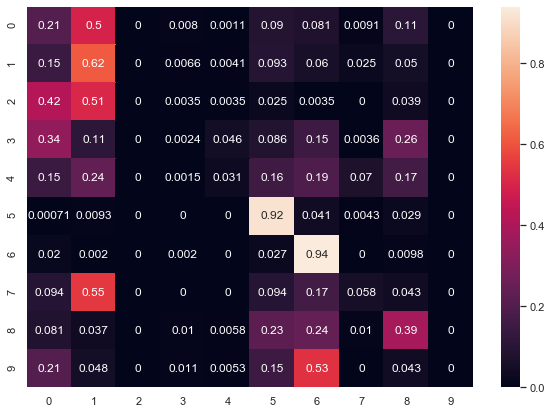

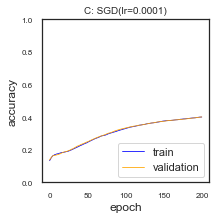

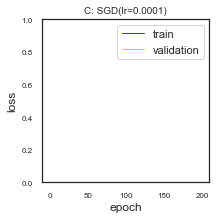

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


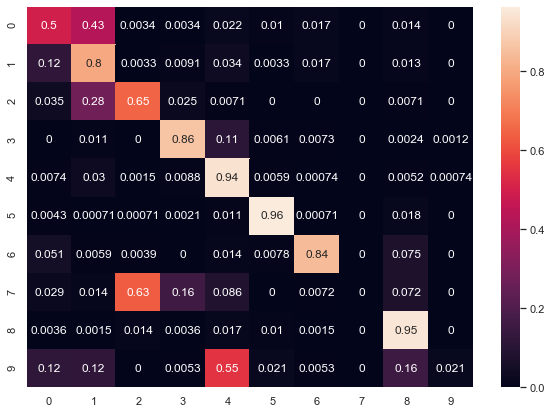

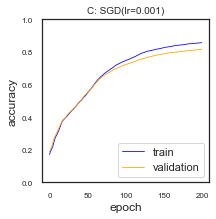

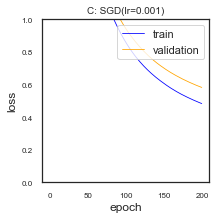

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


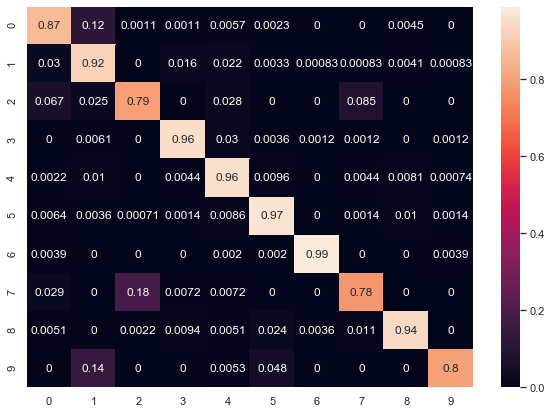

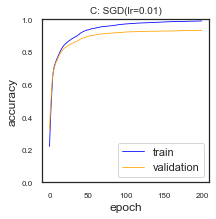

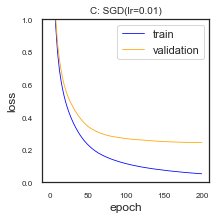

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)


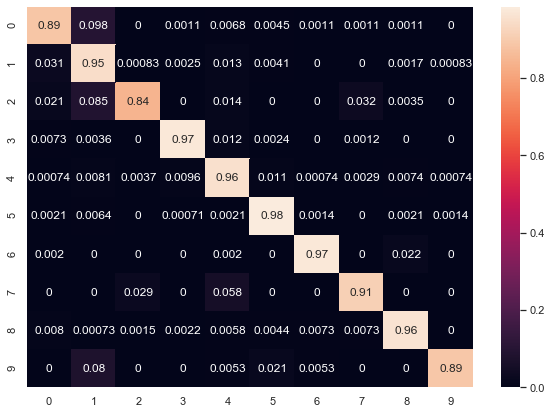

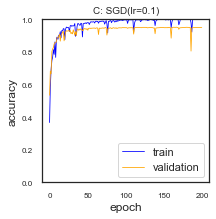

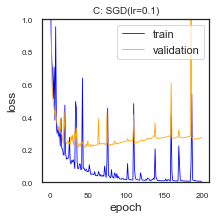

In [502]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "C: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "C: %s" % o.name, 'loss', 'upper right')
    c_metrics_2.loc[len(c_metrics_2)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [503]:
c_metrics_2

classifier       optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]  SGD(lr=0.0001)     190    200  0.400979   0.352993   
1  d=[10, 10, 10]   SGD(lr=0.001)     199    200  0.815789   0.801879   
2  d=[10, 10, 10]    SGD(lr=0.01)     198    200  0.931334   0.932314   
3  d=[10, 10, 10]     SGD(lr=0.1)     202    200  0.949572   0.950417   

     recall  specificity  f1_score       auc  
0  0.400979     0.913075  0.325719  0.606162  
1  0.815789     0.970985  0.798397  0.882394  
2  0.931334     0.989916  0.931323  0.961539  
3  0.949572     0.992346  0.949596  0.971764

#### Impact of Momentum

In [504]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
c_metrics_3 = pd.DataFrame(columns=columns)
c_metrics_3

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [505]:
o1 = SGD(lr=0.01, momentum=0.0, nesterov=False)
o1.name = 'SGD(lr=0.01, m=0.0)'

o2 = SGD(lr=0.01, momentum=0.5, nesterov=False)
o2.name = 'SGD(lr=0.01, m=0.5)'

o3 = SGD(lr=0.01, momentum=0.9, nesterov=False)
o3.name = 'SGD(lr=0.01, m=0.9)'

o4 = SGD(lr=0.01, momentum=0.99, nesterov=False)
o4.name = 'SGD(lr=0.01, m=0.99)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)


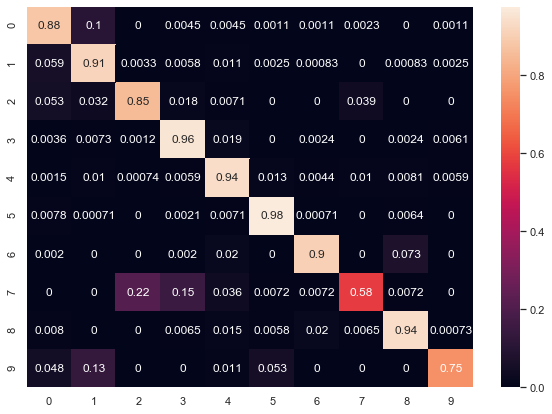

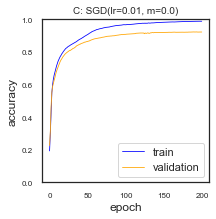

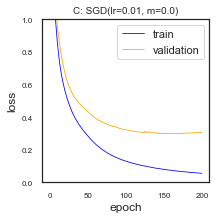

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)


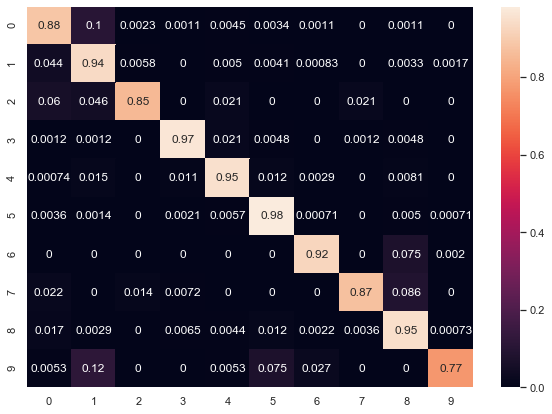

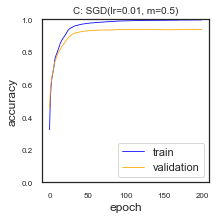

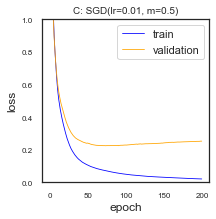

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)


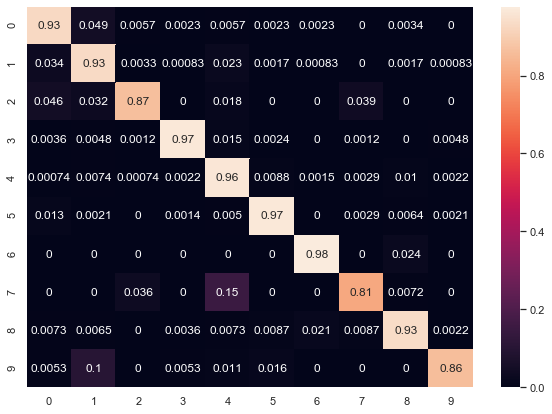

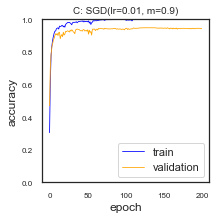

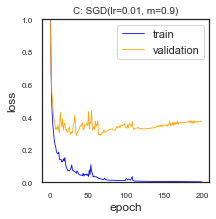

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


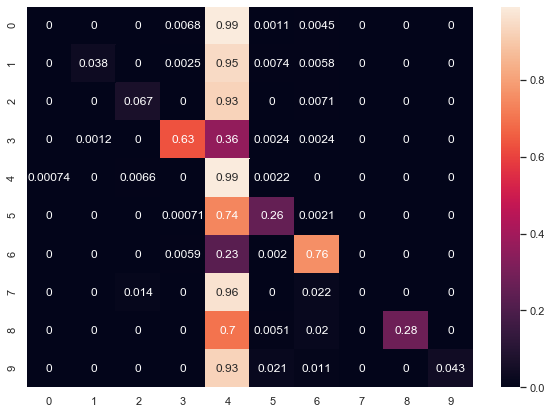

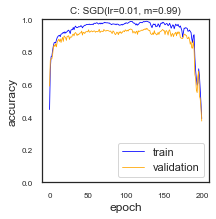

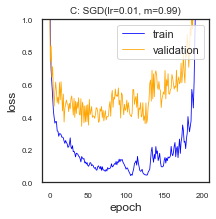

In [506]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "C: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "C: %s" % o.name, 'loss', 'upper right')
    c_metrics_3.loc[len(c_metrics_3)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [507]:
c_metrics_3

classifier             optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]   SGD(lr=0.01, m=0.0)     202    200  0.921542   0.921105   
1  d=[10, 10, 10]   SGD(lr=0.01, m=0.5)     192    200  0.936965   0.937751   
2  d=[10, 10, 10]   SGD(lr=0.01, m=0.9)     202    200  0.943941   0.944490   
3  d=[10, 10, 10]  SGD(lr=0.01, m=0.99)     202    200  0.375643   0.706897   

     recall  specificity  f1_score       auc  
0  0.921542     0.989115  0.921022  0.955511  
1  0.936965     0.989986  0.936801  0.964729  
2  0.943941     0.991955  0.943990  0.968244  
3  0.375643     0.876814  0.345829  0.802364

### Increasing number of epochs

In [508]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
c_metrics_4 = pd.DataFrame(columns=columns)
c_metrics_4

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


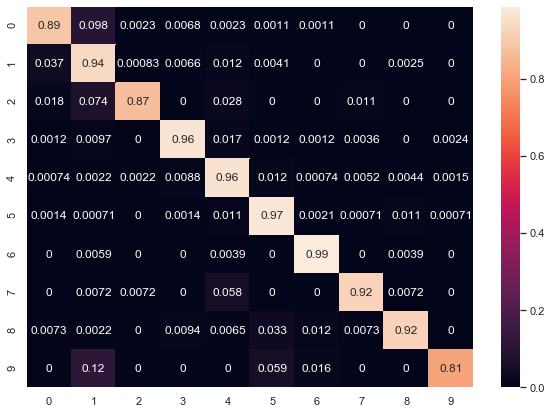

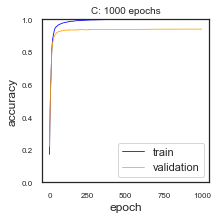

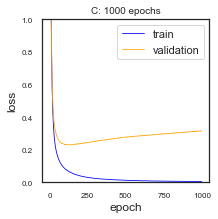

In [509]:
i = 1  # number of iterations
e = 1000
c = default_classifier
o = default_optimizer


start_time = time()
scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
plot_results(t_hist_a, v_hist_a, "C: %s epochs" % e, 'accuracy', 'lower right')
plot_results(t_hist_l, v_hist_l, "C: %s epochs" % e, 'loss', 'upper right')
c_metrics_4.loc[len(c_metrics_4)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [510]:
c_metrics_4

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0  d=[10, 10, 10]  SGD(lr=0.01)     791   1000  0.939535   0.940646  0.939535   

   specificity  f1_score       auc  
0     0.990582   0.93943  0.965947

### Experiment D

In [623]:
_train_x, _train_y, _test_x, _test_y = D_train_x, D_train_y, D_test_x, D_test_y

#### Impact of Network Dimensions

In [624]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
d_metrics_1 = pd.DataFrame(columns=columns)
d_metrics_1

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [625]:
classifier1 = Sequential()
classifier1.name = 'd=[5, 10]'
classifier1.add(Dense(5, input_dim=2304, activation='relu'))
classifier1.add(Dense(10, activation='softmax'))

classifier2 = Sequential()
classifier2.name = 'd=[10, 10]'
classifier2.add(Dense(10, input_dim=2304, activation='relu'))
classifier2.add(Dense(10, activation='softmax'))

classifier3 = Sequential()
classifier3.name = 'd=[30, 10]'
classifier3.add(Dense(30, input_dim=2304, activation='relu'))
classifier3.add(Dense(10, activation='softmax'))

classifier4 = Sequential()
classifier4.name = 'd=[5, 5, 10]'
classifier4.add(Dense(5, input_dim=2304, activation='relu'))
classifier4.add(Dense(5, activation='relu'))
classifier4.add(Dense(10, activation='softmax'))

classifier5 = Sequential()
classifier5.name = 'd=[10, 10, 10]'
classifier5.add(Dense(10, input_dim=2304, activation='relu'))
classifier5.add(Dense(10, activation='relu'))
classifier5.add(Dense(10, activation='softmax'))

classifier6 = Sequential()
classifier6.name = 'd=[30, 30, 10]'
classifier6.add(Dense(30, input_dim=2304, activation='relu'))
classifier6.add(Dense(30, activation='relu'))
classifier6.add(Dense(10, activation='softmax'))

all_classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6]

[1] Running classifier: d=[5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


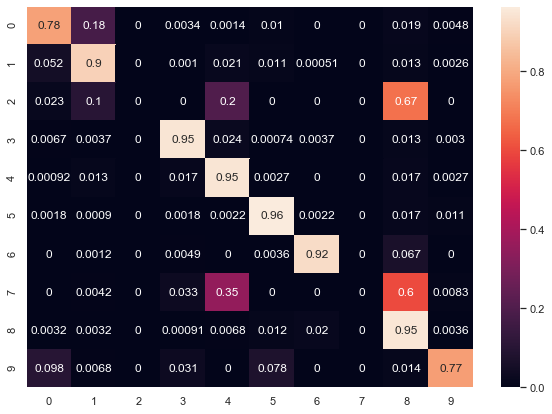

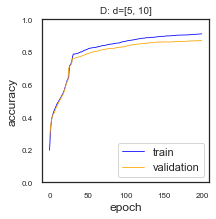

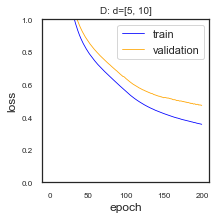

[1] Running classifier: d=[10, 10], SGD(lr=0.01)


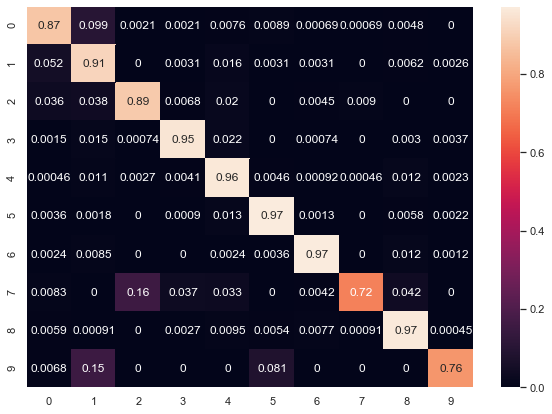

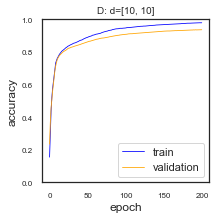

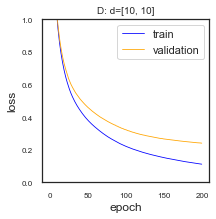

[1] Running classifier: d=[30, 10], SGD(lr=0.01)


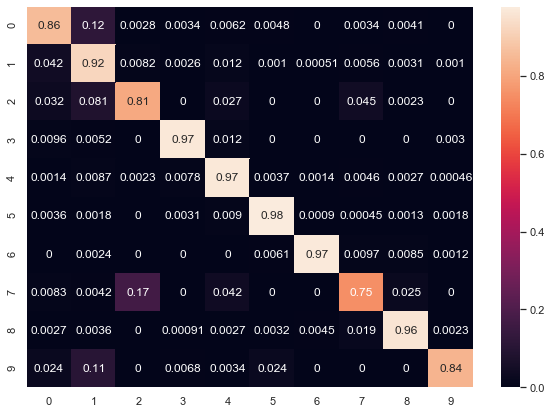

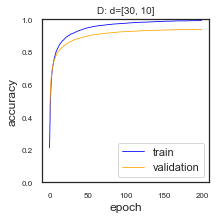

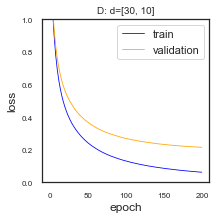

[1] Running classifier: d=[5, 5, 10], SGD(lr=0.01)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


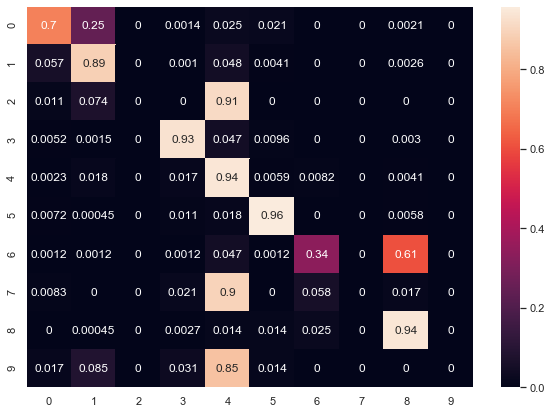

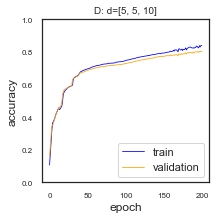

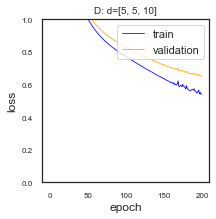

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


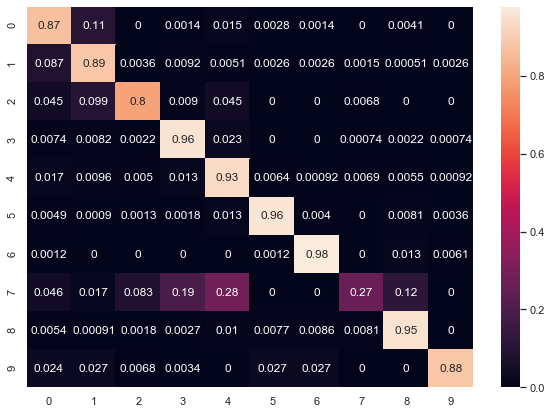

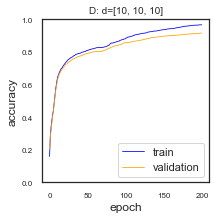

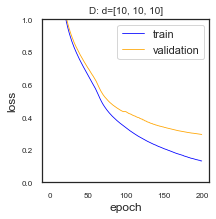

[1] Running classifier: d=[30, 30, 10], SGD(lr=0.01)


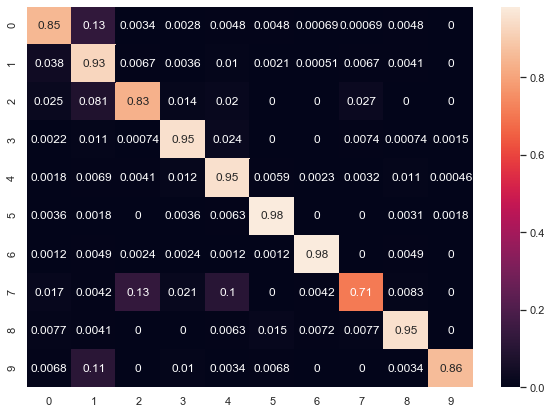

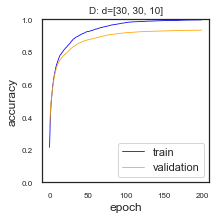

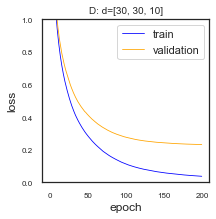

In [626]:
i = 1  # number of iterations
e = default_epochs
o = default_optimizer  # default optimizer

for c in all_classifiers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "D: %s" % c.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "D: %s" % c.name, 'loss', 'upper right')
    d_metrics_1.loc[len(d_metrics_1)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [515]:
d_metrics_1

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0       d=[5, 10]  SGD(lr=0.01)     194    200  0.885725   0.868168  0.885725   
1      d=[10, 10]  SGD(lr=0.01)     185    200  0.929157   0.929212  0.929157   
2      d=[30, 10]  SGD(lr=0.01)     195    200  0.941306   0.942385  0.941306   
3    d=[5, 5, 10]  SGD(lr=0.01)     192    200  0.772513   0.759219  0.772513   
4  d=[10, 10, 10]  SGD(lr=0.01)     193    200  0.909491   0.908399  0.909491   
5  d=[30, 30, 10]  SGD(lr=0.01)     201    200  0.930144   0.930716  0.930144   

   specificity  f1_score       auc  
0     0.982604  0.875366  0.916505  
1     0.989441  0.928674  0.960157  
2     0.991132  0.941025  0.967604  
3     0.960375  0.739985  0.857292  
4     0.987340  0.906591  0.948416  
5     0.989954  0.929869  0.960891

#### Impact of Learning Rate

In [516]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
d_metrics_2 = pd.DataFrame(columns=columns)
d_metrics_2

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [517]:
o1 = SGD(lr=0.0001, nesterov=False)  
o1.name = 'SGD(lr=0.0001)'

o2 = SGD(lr=0.001, nesterov=False)  
o2.name = 'SGD(lr=0.001)'

o3 = SGD(lr=0.01, nesterov=False)  
o3.name = 'SGD(lr=0.01)'

o4 = SGD(lr=0.1, nesterov=False)  
o4.name = 'SGD(lr=0.1)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.0001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


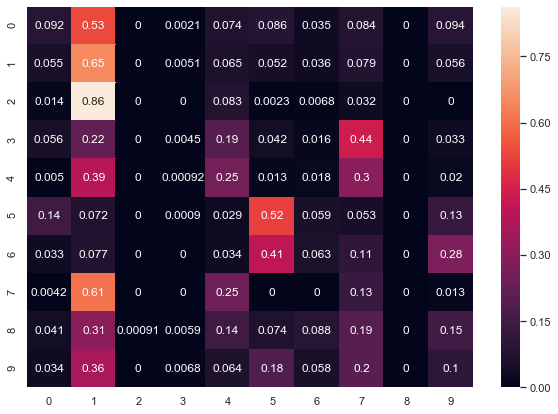

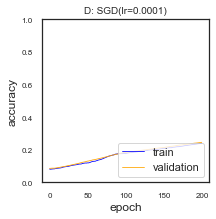

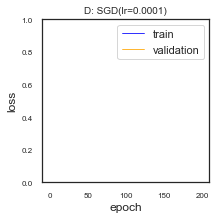

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.001)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


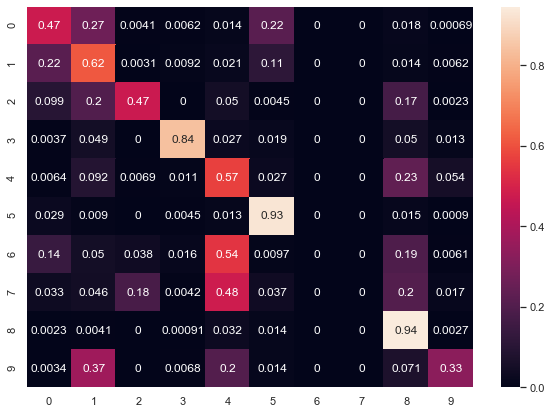

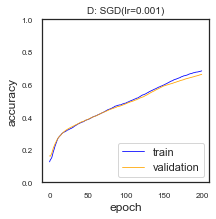

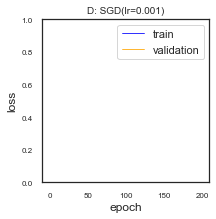

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


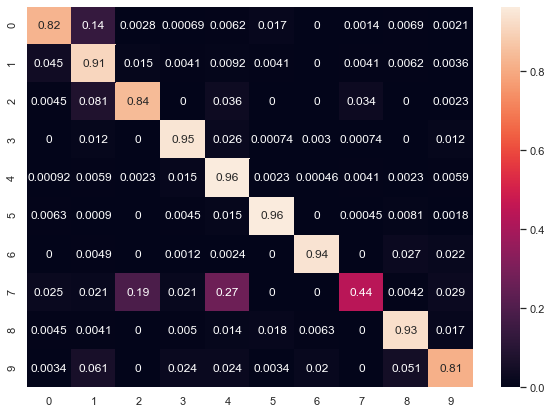

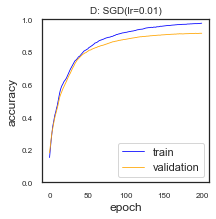

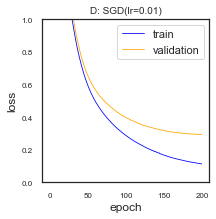

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.1)


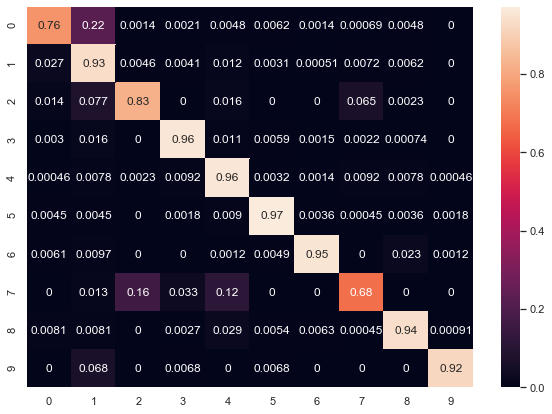

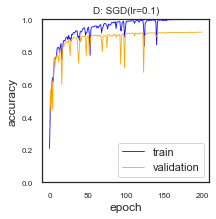

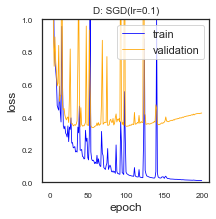

In [518]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "D: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "D: %s" % o.name, 'loss', 'upper right')
    d_metrics_2.loc[len(d_metrics_2)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [519]:
d_metrics_2

classifier       optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]  SGD(lr=0.0001)     191    200  0.245103   0.236227   
1  d=[10, 10, 10]   SGD(lr=0.001)     194    200  0.662111   0.606065   
2  d=[10, 10, 10]    SGD(lr=0.01)     195    200  0.913971   0.914634   
3  d=[10, 10, 10]     SGD(lr=0.1)     216    200  0.920957   0.924051   

     recall  specificity  f1_score       auc  
0  0.245103     0.911465  0.217103  0.494494  
1  0.662111     0.942057  0.627827  0.743356  
2  0.913971     0.987834  0.912923  0.951826  
3  0.920957     0.988035  0.920756  0.956818

#### Impact of Momentum

In [520]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
d_metrics_3 = pd.DataFrame(columns=columns)
d_metrics_3

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

In [521]:
o1 = SGD(lr=0.01, momentum=0.0, nesterov=False)
o1.name = 'SGD(lr=0.01, m=0.0)'

o2 = SGD(lr=0.01, momentum=0.5, nesterov=False)
o2.name = 'SGD(lr=0.01, m=0.5)'

o3 = SGD(lr=0.01, momentum=0.9, nesterov=False)
o3.name = 'SGD(lr=0.01, m=0.9)'

o4 = SGD(lr=0.01, momentum=0.99, nesterov=False)
o4.name = 'SGD(lr=0.01, m=0.99)'

all_optimizers = (o1, o2, o3, o4)

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.0)


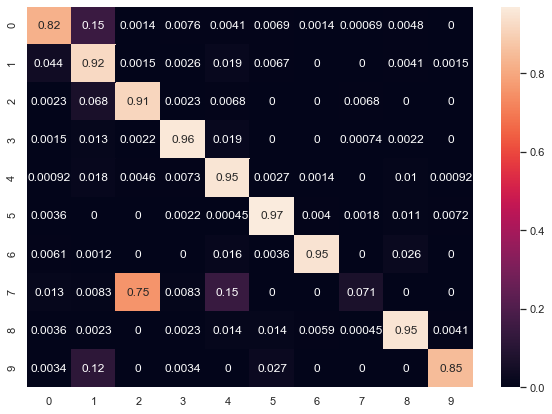

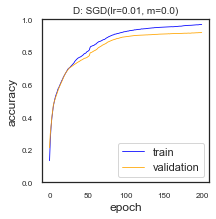

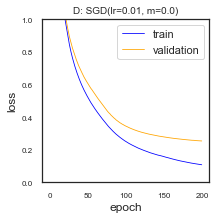

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.5)


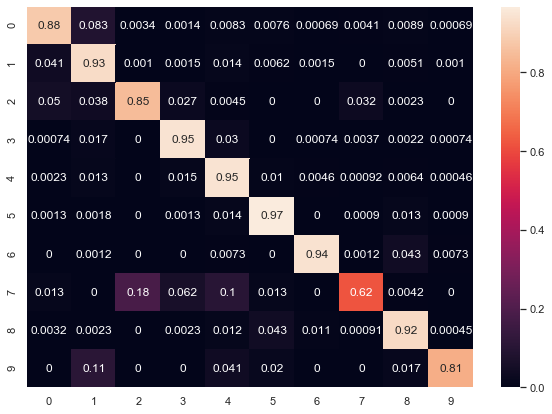

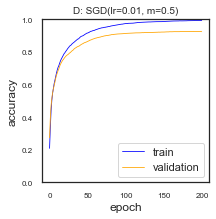

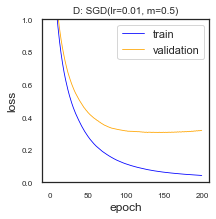

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.9)


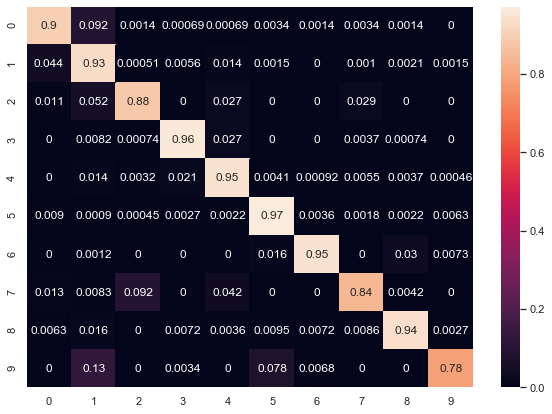

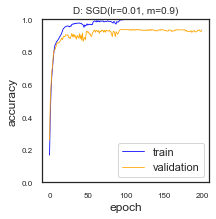

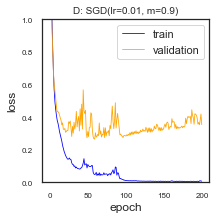

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01, m=0.99)


C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\bscha\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


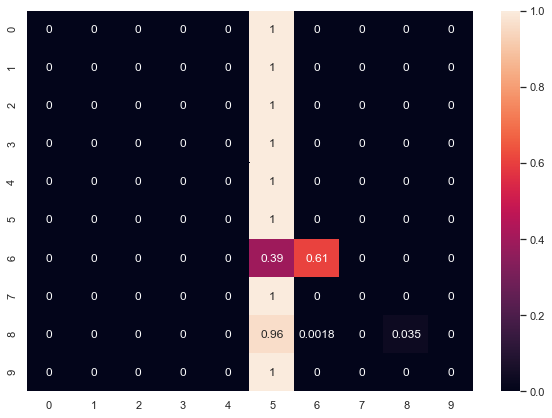

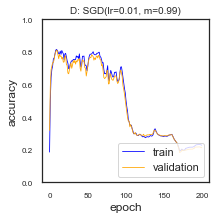

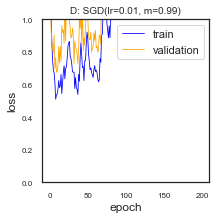

In [522]:
i = 1  # number of iterations
e = default_epochs
c = default_classifier  # default classifier

for o in all_optimizers:
    start_time = time()
    scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
    plot_results(t_hist_a, v_hist_a, "D: %s" % o.name, 'accuracy', 'lower right')
    plot_results(t_hist_l, v_hist_l, "D: %s" % o.name, 'loss', 'upper right')
    d_metrics_3.loc[len(d_metrics_3)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [523]:
d_metrics_3

classifier             optimizer seconds epochs  accuracy  precision  \
0  d=[10, 10, 10]   SGD(lr=0.01, m=0.0)     206    200  0.917844   0.917330   
1  d=[10, 10, 10]   SGD(lr=0.01, m=0.5)     202    200  0.923766   0.923633   
2  d=[10, 10, 10]   SGD(lr=0.01, m=0.9)     220    200  0.934852   0.935968   
3  d=[10, 10, 10]  SGD(lr=0.01, m=0.99)     197    200  0.212604   0.259502   

     recall  specificity  f1_score       auc  
0  0.917844     0.988516  0.912326  0.953787  
1  0.923766     0.988028  0.923108  0.956721  
2  0.934852     0.990730  0.935042  0.963460  
3  0.212604     0.839973  0.108994  0.314841

### Increasing number of epochs

In [524]:
columns=['classifier', 'optimizer', 'seconds', 'epochs', 'accuracy', 'precision', 'recall', 'specificity', 'f1_score', 'auc']
d_metrics_4 = pd.DataFrame(columns=columns)
d_metrics_4

Empty DataFrame
Columns: [classifier, optimizer, seconds, epochs, accuracy, precision, recall, specificity, f1_score, auc]
Index: []

[1] Running classifier: d=[10, 10, 10], SGD(lr=0.01)


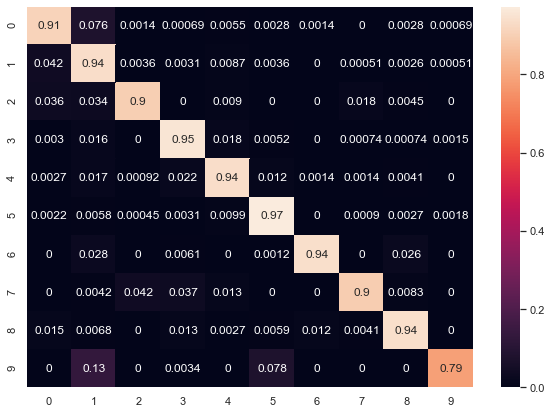

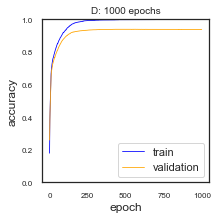

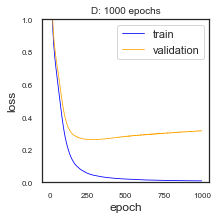

In [525]:
i = 1  # number of iterations
e = 1000  # number of epochs per iteration
c = default_classifier
o = default_optimizer


start_time = time()
scores, t_hist_a, v_hist_a, t_hist_l, v_hist_l = run_classifier(classifier=c, optimizer=o, iterate=i, epochs=e,
                                                                    train_x=_train_x, train_y=_train_y,
                                                                    test_x=_test_x, test_y=_test_y)
plot_results(t_hist_a, v_hist_a, "D: %s epochs" % e, 'accuracy', 'lower right')
plot_results(t_hist_l, v_hist_l, "D: %s epochs" % e, 'loss', 'upper right')
d_metrics_4.loc[len(d_metrics_4)] = [c.name, o.name, round(time() - start_time), e, *pd.DataFrame(scores).mean().tolist()]

In [526]:
d_metrics_4

classifier     optimizer seconds epochs  accuracy  precision    recall  \
0  d=[10, 10, 10]  SGD(lr=0.01)     749   1000  0.937054   0.938392  0.937054   

   specificity  f1_score       auc  
0     0.990512  0.937187  0.964729

### Final Results

In [635]:
a_metrics = a_metrics_1.append(a_metrics_2).append(a_metrics_3).append(a_metrics_4).reset_index()
b_metrics = b_metrics_1.append(b_metrics_2).append(b_metrics_3).append(b_metrics_4).reset_index()
c_metrics = c_metrics_1.append(c_metrics_2).append(c_metrics_3).append(c_metrics_4).reset_index()
d_metrics = d_metrics_1.append(d_metrics_2).append(d_metrics_3).append(d_metrics_4).reset_index()

In [636]:
d_metrics

index      classifier             optimizer seconds epochs  accuracy  \
0       0       d=[5, 10]          SGD(lr=0.01)     353    200  0.869704   
1       1      d=[10, 10]          SGD(lr=0.01)     361    200  0.935459   
2       2      d=[30, 10]          SGD(lr=0.01)     363    200  0.937737   
3       3    d=[5, 5, 10]          SGD(lr=0.01)     332    200  0.802354   
4       4  d=[10, 10, 10]          SGD(lr=0.01)     332    200  0.915034   
5       5  d=[30, 30, 10]          SGD(lr=0.01)     377    200  0.932954   
6       0  d=[10, 10, 10]        SGD(lr=0.0001)     191    200  0.245103   
7       1  d=[10, 10, 10]         SGD(lr=0.001)     194    200  0.662111   
8       2  d=[10, 10, 10]          SGD(lr=0.01)     195    200  0.913971   
9       3  d=[10, 10, 10]           SGD(lr=0.1)     216    200  0.920957   
10      0  d=[10, 10, 10]   SGD(lr=0.01, m=0.0)     206    200  0.917844   
11      1  d=[10, 10, 10]   SGD(lr=0.01, m=0.5)     202    200  0.923766   
12      2  d=[10, 10, 10]   SGD(lr=0.01, m=0.9)     220    200  0.934852   
13      3  d=[10, 10, 10]  SGD(lr=0.01, m=0.99)     197    200  0.212604   
14      0  d=[10, 10, 10]          SGD(lr=0.01)     749   1000  0.937054   

    precision    recall  specificity  f1_score       auc  
0    0.829090  0.869704     0.977317  0.847046  0.882801  
1    0.935803  0.935459     0.990044  0.935045  0.963720  
2    0.939199  0.937737     0.991699  0.938089  0.965617  
3    0.756423  0.802354     0.963731  0.766951  0.833129  
4    0.912720  0.915034     0.987725  0.912372  0.950911  
5    0.933693  0.932954     0.990247  0.932882  0.962416  
6    0.236227  0.245103     0.911465  0.217103  0.494494  
7    0.606065  0.662111     0.942057  0.627827  0.743356  
8    0.914634  0.913971     0.987834  0.912923  0.951826  
9    0.924051  0.920957     0.988035  0.920756  0.956818  
10   0.917330  0.917844     0.988516  0.912326  0.953787  
11   0.923633  0.923766     0.988028  0.923108  0.956721  
12   0.935968  0.934852     0.990730  0.935042  0.963460  
13   0.259502  0.212604     0.839973  0.108994  0.314841  
14   0.938392  0.937054     0.990512  0.937187  0.964729

In [637]:
linear_metrics

classifier  optimizer seconds  epochs  accuracy  precision    recall  \
0     Linear        NaN     595     NaN  0.975276   0.975584  0.975276   
1     Linear        NaN     440     NaN  0.916067   0.917677  0.916067   
2     Linear        NaN     361     NaN  0.943329   0.944030  0.943329   
3     Linear        NaN     242     NaN  0.941913   0.943261  0.941913   

   specificity  f1_score       auc exp  
0     0.996243  0.975312  0.985707   A  
1     0.988299  0.915375  0.952968   B  
2     0.991973  0.943305  0.967888   C  
3     0.991995  0.942269  0.967345   D

In [638]:
a_metrics['exp'] = 'A'
b_metrics['exp'] = 'B'
c_metrics['exp'] = 'C'
d_metrics['exp'] = 'D'

In [642]:
all_metrics = a_metrics.append(b_metrics).append(c_metrics).append(d_metrics).append(linear_metrics)
all_metrics.loc[all_metrics.classifier == 'Linear', 'optimizer'] = ""
all_metrics['model'] = all_metrics['classifier']+', '+all_metrics['optimizer']
all_metrics = all_metrics.sort_values(['exp', 'classifier'])

In [643]:
all_metrics

accuracy       auc      classifier epochs exp  f1_score  index  \
0   0.975276  0.985707          Linear    NaN   A  0.975312    NaN   
4   0.970300  0.983123  d=[10, 10, 10]    200   A  0.970279    4.0   
6   0.404265  0.615113  d=[10, 10, 10]    200   A  0.341587    0.0   
7   0.848420  0.881773  d=[10, 10, 10]    200   A  0.825722    1.0   
8   0.968088  0.981888  d=[10, 10, 10]    200   A  0.968013    2.0   
..       ...       ...             ...    ...  ..       ...    ...   
1   0.935459  0.963720      d=[10, 10]    200   D  0.935045    1.0   
2   0.937737  0.965617      d=[30, 10]    200   D  0.938089    2.0   
5   0.932954  0.962416  d=[30, 30, 10]    200   D  0.932882    5.0   
0   0.869704  0.882801       d=[5, 10]    200   D  0.847046    0.0   
3   0.802354  0.833129    d=[5, 5, 10]    200   D  0.766951    3.0   

         optimizer  precision    recall seconds  specificity  \
0                    0.975584  0.975276     595     0.996243   
4     SGD(lr=0.01)   0.970525  0.970300    1780     0.995699   
6   SGD(lr=0.0001)   0.411619  0.404265    2158     0.902374   
7    SGD(lr=0.001)   0.818372  0.848420    2010     0.974243   
8     SGD(lr=0.01)   0.968346  0.968088    2009     0.995442   
..             ...        ...       ...     ...          ...   
1     SGD(lr=0.01)   0.935803  0.935459     361     0.990044   
2     SGD(lr=0.01)   0.939199  0.937737     363     0.991699   
5     SGD(lr=0.01)   0.933693  0.932954     377     0.990247   
0     SGD(lr=0.01)   0.829090  0.869704     353     0.977317   
3     SGD(lr=0.01)   0.756423  0.802354     332     0.963731   

                             model  
0                         Linear,   
4     d=[10, 10, 10], SGD(lr=0.01)  
6   d=[10, 10, 10], SGD(lr=0.0001)  
7    d=[10, 10, 10], SGD(lr=0.001)  
8     d=[10, 10, 10], SGD(lr=0.01)  
..                             ...  
1         d=[10, 10], SGD(lr=0.01)  
2         d=[30, 10], SGD(lr=0.01)  
5     d=[30, 30, 10], SGD(lr=0.01)  
0          d=[5, 10], SGD(lr=0.01)  
3       d=[5, 5, 10], SGD(lr=0.01)  

[64 rows x 13 columns]

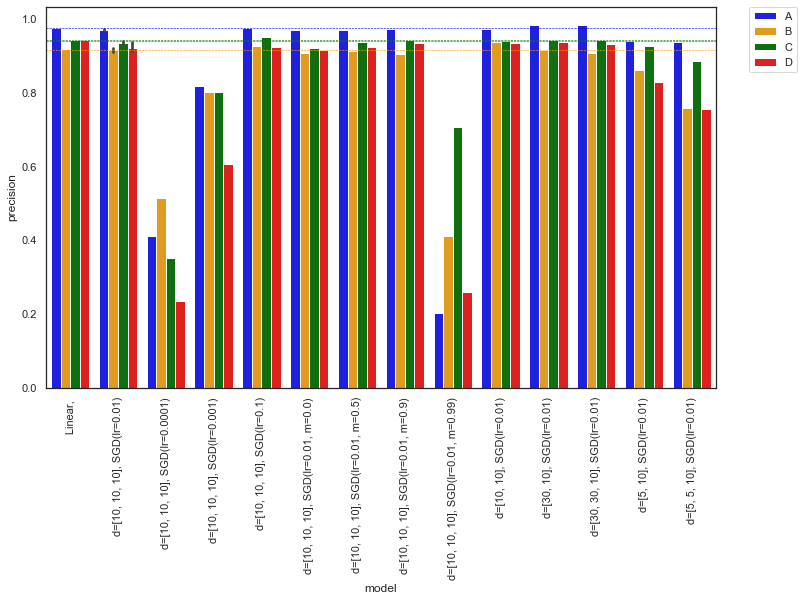

In [644]:
import seaborn as sns
plt.figure(figsize = (12,7))
sns.set(style="white")
ax = sns.barplot(x="model", y="precision", hue="exp", data=all_metrics, palette=['blue', 'orange', 'green', 'red'])
ax.axhline(all_metrics.loc[(all_metrics.classifier == 'Linear') & (all_metrics.exp == 'A'), 'accuracy'].values, c='blue', linestyle='--', linewidth=0.6)
ax.axhline(all_metrics.loc[(all_metrics.classifier == 'Linear') & (all_metrics.exp == 'B'), 'accuracy'].values, c='orange', linestyle='--', linewidth=0.6)
ax.axhline(all_metrics.loc[(all_metrics.classifier == 'Linear') & (all_metrics.exp == 'C'), 'accuracy'].values, c='green', linestyle='--', linewidth=0.6)
ax.axhline(all_metrics.loc[(all_metrics.classifier == 'Linear') & (all_metrics.exp == 'D'), 'accuracy'].values, c='red', linestyle='--', linewidth=0.6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Training Chosen Model

In [659]:

# create train and test sets
train_x, test_x = B_train_x, B_test_x
train_y, test_y = B_train_y, B_test_y

# build and fit model
default_classifier.compile(loss='sparse_categorical_crossentropy', optimizer=default_optimizer, metrics=['sparse_categorical_accuracy'])
default_classifier.fit(train_x, train_y, epochs=200, validation_data=(test_x, test_y), shuffle=False, batch_size=256, verbose=1)        

scores = default_classifier.predict(test_x, batch_size=1, verbose=0)
predictions = np.array([np.argmax(x) for x in scores])


Train on 12660 samples, validate on 4170 samples
Epoch 1/200
12660/12660 [==============================] - 24s 2ms/step - loss: 0.0117 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.4193 - val_sparse_categorical_accuracy: 0.9264
Epoch 2/200
12660/12660 [==============================] - 1s 92us/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.9264
Epoch 3/200
12660/12660 [==============================] - 1s 94us/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.9266
Epoch 4/200
12660/12660 [==============================] - 1s 94us/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4203 - val_sparse_categorical_accuracy: 0.9266
Epoch 5/200
12660/12660 [==============================] - 1s 95us/step - loss: 0.0112 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4199 - val_sparse_categorical_accuracy: 0.9266
Epoch 6/200
12660/126

12660/12660 [==============================] - 1s 110us/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4265 - val_sparse_categorical_accuracy: 0.9273
Epoch 45/200
12660/12660 [==============================] - 1s 109us/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4268 - val_sparse_categorical_accuracy: 0.9273
Epoch 46/200
12660/12660 [==============================] - 1s 110us/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.9273
Epoch 47/200
12660/12660 [==============================] - 1s 110us/step - loss: 0.0096 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.9276
Epoch 48/200
12660/12660 [==============================] - 1s 112us/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4269 - val_sparse_categorical_accuracy: 0.9276
Epoch 49/200
12660/12660 [==============================] - 1s 115us/step

Epoch 88/200
12660/12660 [==============================] - 1s 114us/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4324 - val_sparse_categorical_accuracy: 0.9281
Epoch 89/200
12660/12660 [==============================] - 1s 115us/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4325 - val_sparse_categorical_accuracy: 0.9285
Epoch 90/200
12660/12660 [==============================] - 1s 115us/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4326 - val_sparse_categorical_accuracy: 0.9281
Epoch 91/200
12660/12660 [==============================] - 1s 114us/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4326 - val_sparse_categorical_accuracy: 0.9281
Epoch 92/200
12660/12660 [==============================] - 1s 115us/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.4330 - val_sparse_categorical_accuracy: 0.9281
Epoch 93/200
12660/12660 [==============================] - 

12660/12660 [==============================] - 1s 114us/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.4372 - val_sparse_categorical_accuracy: 0.9285
Epoch 132/200
12660/12660 [==============================] - 1s 112us/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.4372 - val_sparse_categorical_accuracy: 0.9285
Epoch 133/200
12660/12660 [==============================] - 1s 113us/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.4373 - val_sparse_categorical_accuracy: 0.9288
Epoch 134/200
12660/12660 [==============================] - 1s 113us/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.4373 - val_sparse_categorical_accuracy: 0.9283
Epoch 135/200
12660/12660 [==============================] - 1s 114us/step - loss: 0.0072 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.4376 - val_sparse_categorical_accuracy: 0.9285
Epoch 136/200
12660/12660 [==============================] - 1s 114us

12660/12660 [==============================] - 1s 104us/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.4416 - val_sparse_categorical_accuracy: 0.9288
Epoch 175/200
12660/12660 [==============================] - 1s 106us/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.4412 - val_sparse_categorical_accuracy: 0.9288
Epoch 176/200
12660/12660 [==============================] - 1s 110us/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.4417 - val_sparse_categorical_accuracy: 0.9288
Epoch 177/200
12660/12660 [==============================] - 1s 112us/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.4416 - val_sparse_categorical_accuracy: 0.9288
Epoch 178/200
12660/12660 [==============================] - 1s 110us/step - loss: 0.0064 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.4419 - val_sparse_categorical_accuracy: 0.9290
Epoch 179/200
12660/12660 [==============================] - 1s 111us

#### Examples of misclassified images

In [661]:
# find misclassified images

misclassified = []
for i in range(len(predictions)):
    if test_y[i] != predictions[i]:
        misclassified.append(i)

print("model misclassified %s out of %s images" % (len(misclassified), len(predictions)))

model misclassified 295 out of 4170 images


In [653]:
import matplotlib.pyplot as plt

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape(48,48), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label.astype(np.int)].set_color('blue')

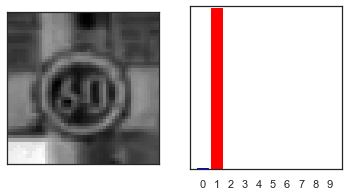

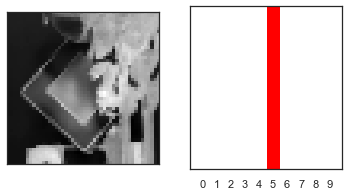

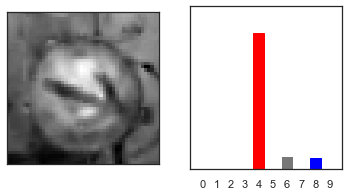

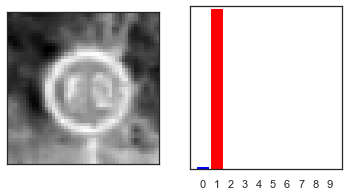

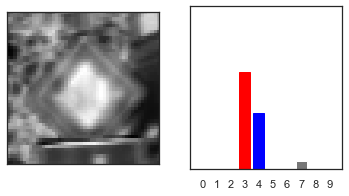

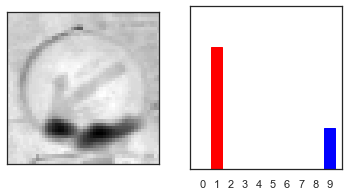

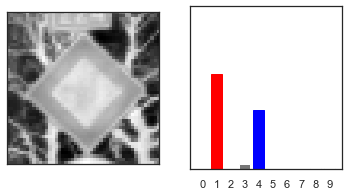

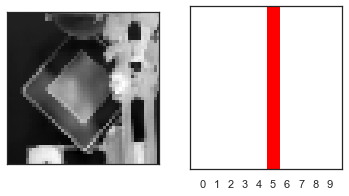

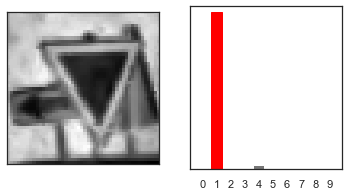

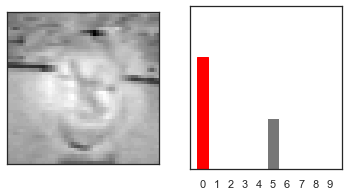

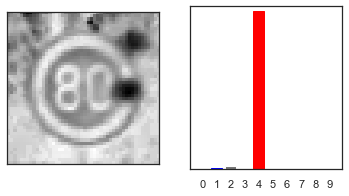

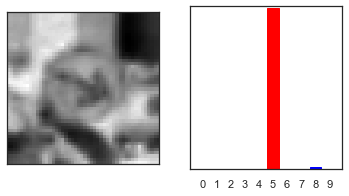

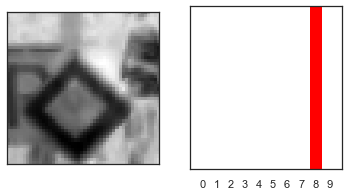

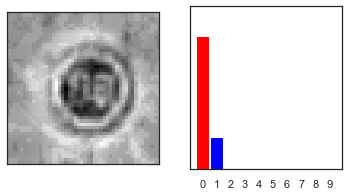

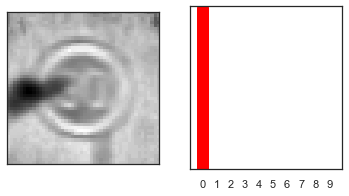

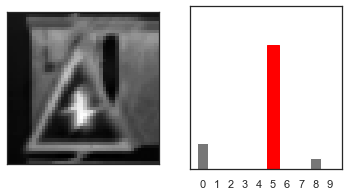

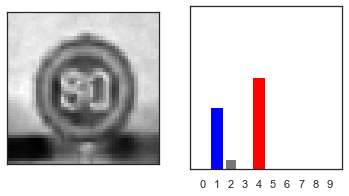

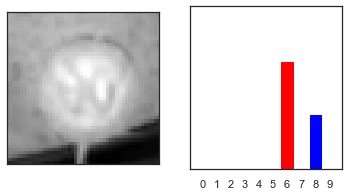

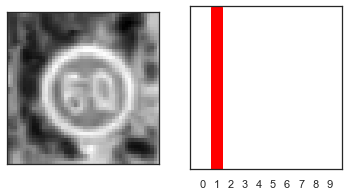

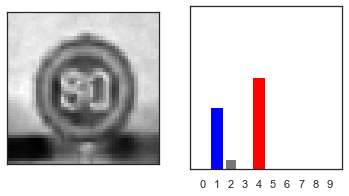

In [665]:
import random

n = 20
rc = np.random.choice(misclassified, n)
for i in rc:
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_image(i, scores[i], test_y, test_x)
    plt.subplot(1,2,2)
    plot_value_array(i, scores[i],  test_y)
    plt.show()